# Demande immobilière en France

*Par Yanis Larré, Tom Croquette et Renan Romariz.*


## Introduction 

Ce projet s’inscrit dans le prolongement des débats récents portant sur les déterminants territoriaux de la demande immobilière en France. Dans un contexte marqué par de fortes disparités spatiales, la dynamique des marchés immobiliers varie considérablement selon les communes et les départements, tant en termes de prix au mètre carré que de volume de transactions. Ces écarts soulèvent des questions importantes quant aux facteurs économiques, sociaux et institutionnels qui structurent l’attractivité résidentielle des territoires.

L’analyse de la demande immobilière s’est longtemps concentrée sur des variables macroéconomiques classiques telles que les revenus, les taux d’intérêt ou la démographie. Toutefois, ces approches peinent parfois à rendre compte des différences observées à un niveau géographique fin. Dès lors, il apparaît pertinent d’élargir l’analyse à des indicateurs reflétant plus directement la qualité de vie et l’environnement socio-économique local, susceptibles d’influencer les choix résidentiels des ménages.

L’objectif de ce projet est d’étudier la relation entre la demande immobilière — mesurée par le prix au mètre carré et le nombre de ventes — et plusieurs caractéristiques locales des communes et départements français. Parmi les variables explicatives retenues figurent notamment la présence de services de proximité, approchée par le nombre de pharmacies, le niveau de développement humain (IDH), ainsi que le taux de criminalité. Ces variables peuvent être interprétées comme des proxies de l’accessibilité aux services, du bien-être socio-économique et du sentiment de sécurité, dimensions susceptibles de jouer un rôle central dans l’attractivité immobilière.

On peut en effet formuler l’hypothèse qu’un meilleur accès aux services de santé, un niveau de développement humain élevé et un environnement plus sûr contribuent à accroître la demande immobilière, se traduisant par des prix plus élevés et un plus grand nombre de transactions. Inversement, un niveau élevé de criminalité pourrait constituer un facteur dissuasif pour les ménages, pesant négativement sur l’activité du marché immobilier local.

Ce projet vise ainsi à estimer, à l’aide de modèles de régression, l’impact de ces caractéristiques territoriales sur la demande immobilière en France, afin de mieux comprendre les mécanismes sous-jacents aux inégalités spatiales observées sur le marché du logement.


## Sommaire

* [I. Installation et configuration](#installation-et-configuration)

* [II. Collecte et préparation des données](#collecte-et-preparation-des-donnees)
  * [1. Données immobilières DVF](#donnees-dvf)
  * [2. Données démographiques](#donnees-demographiques)
  * [3. Calcul des prix au mètre carré](#calcul-prix-m2)
  * [4. Constitution du dataset final](#dataset-final)

* [III. Analyse exploratoire et visualisations](#analyse-exploratoire)
  * [1. Distribution des surfaces immobilières](#distribution-surfaces)
  * [2. Relation entre prix et surface](#relation-prix-surface)
  * [3. Analyse de la densité de population](#analyse-densite)

* [IV. Modélisation économétrique](#modelisation-econometrique)
  * [1. Fondements théoriques et méthodologiques](#fondements-theoriques)
  * [2. Sélection des variables explicatives](#selection-variables)
  * [3. Préparation des données de régression](#preparation-regression)
  * [4. Interprétation des résultats](#interpretation-resultats)

* [V. Conclusion et perspectives](#conclusion)
  * [1. Synthèse des résultats](#synthese-resultats)
  * [2. Implications pour la politique du logement](#implications-politiques)
  * [3. Limites méthodologiques](#limites-methodologiques)
  * [4. Pistes d'amélioration et recherches futures](#pistes-amelioration)
  * [5. Conclusion générale](#conclusion-generale)

## I. Installation et configuration

Avant de débuter l'analyse, nous devons mettre en place l'environnement de travail. Cette étape garantit que toutes les dépendances nécessaires sont installées et que nos fonctions personnalisées sont chargées (elles sont stockées dans les différents fichiers de code du dossier *scripts*).

### Installation des dépendances

Nous utilisons un fichier `requirements.txt` qui liste l'ensemble des bibliothèques Python nécessaires au projet : pandas pour la manipulation de données, plotly et matplotlib pour les visualisations, s3fs pour l'accès aux données sur le cloud, etc.

In [1]:
!pip install -r requirements.txt

# Modules :
import os
import s3fs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Fonctions :
from scripts import get_data
from scripts import data_clean
from scripts import data_analysis
from scripts import data_visualization
from scripts import do_ols
from scripts import getvis
from scripts import global_variables

In [2]:
# Reload automatique pour travailler en continu :

%load_ext autoreload
%autoreload 2

## II. Collecte et préparation des données

Cette section constitue le cœur du travail de préparation des données. Elle comprend la collecte, le nettoyage et la transformation des données brutes en un dataset exploitable pour l'analyse.

### 1. Données immobilières DVF

#### Source des données

Nous utilisons les données DVF (Demandes de Valeurs Foncières) mises à disposition par la Direction Générale des Finances Publiques (DGFiP) sur [data.gouv.fr](https://www.data.gouv.fr). Cette base de données recense l'ensemble des transactions immobilières réalisées en France sur les 5 dernières années (2020-2025).

Ces données couvrent la quasi-totalité du territoire français, mais avec quelques exceptions notables :
- Mayotte : les données sont tout simplement non disponibles.
- Alsace-Moselle (départements 57, 67 et 68) : ces territoires utilisent le régime du *Livre Foncier*, hérité de l'annexion allemande de 1871-1918. Leurs transactions ne sont pas centralisées dans la base DVF nationale.

Ces exclusions représentent environ 3% de la population française et devront être prises en compte dans l'interprétation de nos résultats. Toutefois, dans l'analyse des déterminants du prix au mètre carré et de la demande de logement, nous pouvons nous concentrer sur les données disponibles.

#### Récupération des données

Les données sont stockées sur le cloud et récupérées via notre fonction `get_cloud_csv()` :


In [3]:
df = get_data.get_cloud_csv('dvf')

/home/onyxia/work/Python_2A/scripts/get_data.py:40: DtypeWarning: Columns (12,14,16,17,18,20,22,24,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


#### 1.3 Filtrage par type de bien

**Justification du choix :** La base DVF contient de nombreux types de biens immobiliers (terrains agricoles, locaux commerciaux, dépendances isolées, etc.). Nous restreignons notre analyse aux **maisons et appartements** car :

1. **Pertinence économique :** Ces deux catégories représentent l'essentiel du marché résidentiel et répondent à une demande de logement des ménages, contrairement aux terrains nus ou locaux professionnels.

2. **Qualité des données :** Les maisons et appartements disposent d'informations complètes et standardisées : prix de vente, surface habitable, localisation précise.

3. **Comparabilité :** Ces biens partagent des caractéristiques communes permettant des comparaisons pertinentes entre territoires.

Ce filtrage concentre l'analyse sur le **marché résidentiel**, objet central de notre problématique sur l'attractivité territoriale.


In [4]:
df = df[df['type_local'].isin(['Maison', 'Appartement'])]
df = df.reset_index()

In [5]:
df['type_local'].value_counts()

type_local
Maison         3370550
Appartement    2876665
Name: count, dtype: int64

#### 1.4 Harmonisation des codes communes

**Problème identifié :** Les codes INSEE des communes présentent une **incohérence de typage** dans les données brutes : certains sont enregistrés comme des entiers (`int`), d'autres comme des chaînes de caractères (`str`).

**Choix technique :** Nous convertissons l'ensemble des codes en type `string` pour deux raisons :

1. **Codes alphanumériques :** La Corse utilise des codes commençant par `2A` (Corse-du-Sud) et `2B` (Haute-Corse), qui ne peuvent pas être représentés en entiers.

2. **Uniformité :** Un typage unique facilite les jointures ultérieures avec d'autres bases de données (populations, indicateurs INSEE) et évite les erreurs de fusion.

3. **Préservation des zéros initiaux :** Certains codes commencent par 0 (exemple : `01001` pour Abergement-Clémenciat), information perdue en format entier.

In [6]:
data_clean.convertir_codes_communes(df)
print(df['code_commune'])

0          01130
1          01451
2          01364
3          01053
4          01177
           ...  
6247210    75111
6247211    75112
6247212    75116
6247213    75113
6247214    75105
Name: code_commune, Length: 6247215, dtype: object


#### 1.5 Élimination des ventes en lots

**Identification du problème :** Certaines transactions concernent plusieurs biens vendus simultanément (ventes groupées). Dans la base DVF, ces ventes sont identifiables par un même `id_mutation` apparaissant sur plusieurs lignes.

**Pourquoi éliminer les lots ?**

1. **Indivisibilité du prix :** Impossible de déterminer la valeur individuelle de chaque bien dans un lot. Le prix global ne reflète pas nécessairement la somme des valeurs unitaires (effets de bundle, remises).

2. **Biais de marché :** Les ventes en lots concernent majoritairement :
   - Des programmes neufs vendus par des promoteurs
   - Des opérations d'investissement locatif
   - Des acquisitions foncières pour opérations d'aménagement
   
   Ces transactions ne relèvent pas du même marché que les acquisitions individuelles de résidences principales.

3. **Cohérence de l'analyse :** Nous souhaitons étudier le **marché de l'occasion** et les choix résidentiels des ménages, où les prix reflètent les préférences individuelles et l'attractivité territoriale.

**Méthode :** Nous conservons uniquement les transactions dont l'`id_mutation` n'apparaît qu'une seule fois dans la base.

In [7]:
# Comptage du nombre de lignes par id_mutation
comptage_df = df['id_mutation'].value_counts().reset_index()
comptage_df.columns = ['id_mutation', 'nombre_de_lignes']


print("Exemples d'identifiants de mutation multiples :")
print(comptage_df.head(5)) 

# Identification des id_mutation uniques
id_uniques = comptage_df[comptage_df['nombre_de_lignes'] == 1]
print(f"\nNombre d'identifiants uniques (présents une seule fois) : {id_uniques.shape[0]}")

# Création du DataFrame sans les lots (id_mutation multiples)
df_sans_lots = df[df['id_mutation'].isin(id_uniques['id_mutation'])]
print(f"\nNombre de lignes dans le DataFrame sans lots : {df_sans_lots.shape[0]}")

# Pourcentage de ventes correspondant aux lots
pourcentage_lots = 100 * (df.shape[0] - df_sans_lots.shape[0]) / df.shape[0]
print(f"Pourcentage de ventes correspondant aux lots (éliminées): {pourcentage_lots:.2f}%")



Exemples d'identifiants de mutation multiples :
   id_mutation  nombre_de_lignes
0  2021-687176              9290
1  2022-919567              7657
2  2022-909252              7477
3  2021-342324              7112
4  2020-491811              6173

Nombre d'identifiants uniques (présents une seule fois) : 4133749

Nombre de lignes dans le DataFrame sans lots : 4133749
Pourcentage de ventes correspondant aux lots (éliminées): 33.83%


#### 1.6 Premiers aperçus et statistiques descriptives

Après ces opérations de nettoyage, nous disposons d'une base de données épurée contenant uniquement des transactions individuelles de maisons et d'appartements. 

**Visualisation de la répartition spatiale :** Une première exploration consiste à cartographier le nombre de transactions par commune. Cette représentation permet d'identifier :
- Les zones les plus dynamiques du marché immobilier
- Les disparités territoriales dans l'activité transactionnelle
- Les éventuelles concentrations urbaines

In [ ]:
data_visualization.carte_repartition_ventes(df)

NameError: name 'df_sans_lots_tronqué' is not defined

**Résultats de l'analyse des ventes par commune :**

L'agrégation des transactions par commune révèle que **Toulouse** (code INSEE 31555) est la ville la plus active avec **41 722 ventes** sur la période 2020-2025. Ce résultat s'explique par la forte croissance démographique de la métropole toulousaine et son dynamisme économique.

**Note méthodologique importante :** Les arrondissements de Paris sont traités comme des communes distinctes dans notre analyse. Ce choix se justifie par :
- Une forte hétérogénéité socio-économique entre arrondissements (le 16ème et le 19ème n'ont pas les mêmes caractéristiques)
- Des marchés immobiliers très différenciés en termes de prix et de typologie de biens
- La nécessité de conserver une granularité fine pour l'analyse intra-urbaine

**Rappel :** Ces chiffres excluent les ventes en lots, qui ont été filtrées lors de l'étape précédente.

In [ ]:
# --- Chargement du CSV des communes ---
communes_df = pd.read_csv('Données/liste_communes.csv', sep=',', quotechar='"')

# --- Normalisation des codes INSEE ---
df['code_commune'] = df['code_commune'].astype(str).str.zfill(5)
communes_df['COM'] = communes_df['COM'].astype(str).str.zfill(5)

# --- Comptage des ventes par code_commune ---
ventes_par_commune = df['code_commune'].value_counts().reset_index(name='nombre')
ventes_par_commune.rename(columns={'index':'code_commune'}, inplace=True)

# --- Ajout du nom des communes ---
ventes_par_commune = (ventes_par_commune.merge(
    communes_df[['COM','NCCENR']].rename(columns={'COM':'code_commune','NCCENR':'nom_commune'}),
    on='code_commune',
    how='left'
)).copy()

/home/onyxia/work/Python_2A/scripts/data_analysis.py:112: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




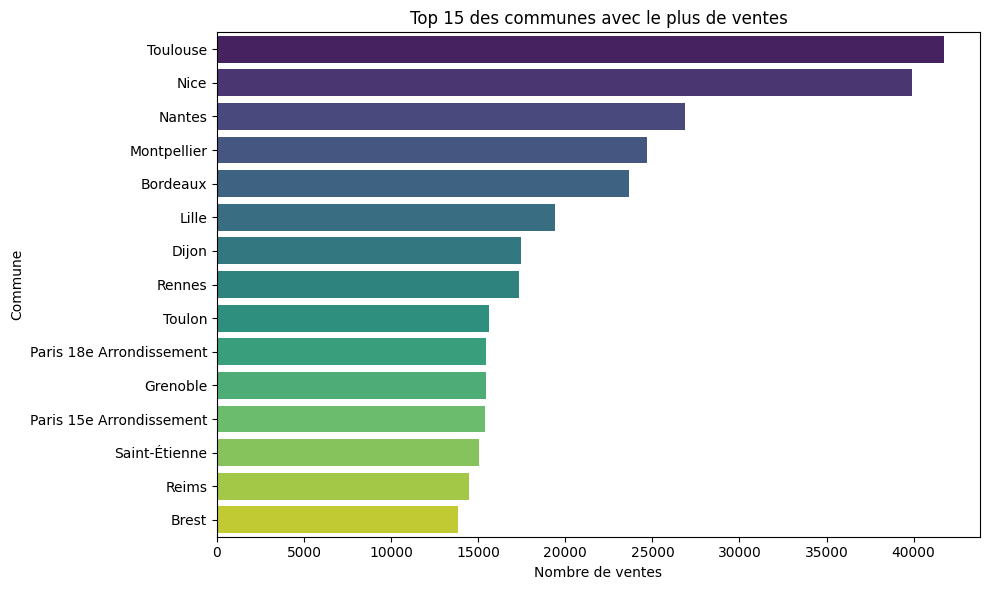

In [ ]:
data_analysis.graph_ventes_par_communes(ventes_par_commune)

### 2. Données démographiques

#### 2.1 Justification et source des données

Pour contextualiser l'activité immobilière et calculer des **indicateurs relatifs** (taux de transaction par habitant), nous devons croiser les données DVF avec les statistiques démographiques communales.

**Pourquoi utiliser les données de population ?**
- Calculer un **taux de rotation du parc immobilier** (nombre de ventes / population)
- Normaliser les volumes de transactions pour comparer des communes de tailles différentes
- Identifier les communes où le marché est particulièrement dynamique relativement à leur taille

**Source :** Nous utilisons les données du **Recensement de la Population 2019** de l'INSEE, dernières données complètes disponibles avant la période d'étude (2020-2025). Ces données fournissent la population municipale légale par commune.

In [ ]:
df_pop = get_data.get_pop()

#### 2.2 Qualité des données et premières observations

**Valeurs manquantes :** Certaines communes présentent des données de population non renseignées ou manquantes. Cela peut concerner :
- Des communes nouvelles créées récemment par fusion
- Des communes ayant changé de code INSEE
- Des erreurs de saisie dans la base

**Communes à très faible population :** On observe également des communes avec une population extrêmement réduite (moins de 10 habitants). Ces cas particuliers devront être traités avec précaution lors du calcul des ratios ventes/habitant pour éviter des valeurs aberrantes.

#### 2.3 Harmonisation des codes INSEE pour les DOM

**Problème technique identifié :** Les codes communes des Départements d'Outre-Mer (DOM) présentent une **incohérence de format** entre nos deux sources de données :

| Territoire | Code dans DVF | Code dans données INSEE | Statut |
|------------|---------------|-------------------------|---------|
| Guadeloupe | 971XX (5 chiffres) | 971XX (5 chiffres) | ✓ Compatible |
| Martinique | 972XX (5 chiffres) | 972XX (5 chiffres) | ✓ Compatible |
| Guyane | 973XX (5 chiffres) | 973XX (5 chiffres) | ✓ Compatible |
| La Réunion | 97421 (5 chiffres) | **974**421 (6 chiffres) | ✗ Incompatible |
| Mayotte | 976XX (5 chiffres) | 976XX (5 chiffres) | ✓ Compatible |

**Origine du problème :** Historiquement, l'INSEE utilise parfois un code département à 3 chiffres pour La Réunion (974) au lieu de 2 chiffres (97), ce qui produit des codes communes à 6 chiffres (ex: Salazie = 974421).

**Solution appliquée :** Pour assurer la compatibilité entre les deux bases, nous supprimons le 3ème chiffre des codes à 6 chiffres pour les ramener au format standard à 5 chiffres utilisé dans DVF (974421 → 97421).

Cette opération est réalisée uniquement pour les codes DOM concernés via la fonction `enleverchiffreDOMs()`.

In [ ]:
# Problème des codes communes à 6 chiffres :
print(df_pop[df_pop['code_commune']=='974421'])
lignes_6_chiffres = df_pop[df_pop["code_commune"].str.len() == 6]
print(lignes_6_chiffres)
print(df_pop[df_pop['code_commune']=='974421']['libgeo'])
print(df[df['code_commune']=='97421']['nom_commune'])

      objectid  reg  dep     cv code_commune   libgeo  p13_pop  p14_pop  \
3786    131030    4  974  97406       974421  Salazie   7226.0   7132.0   

      p15_pop  p16_pop  p17_pop  p18_pop  p19_pop  p20_pop  p21_pop  
3786   7384.0   7400.0     7312   7224.0   7136.0   7310.0   7243.0  
       objectid  reg  dep     cv code_commune                  libgeo  \
84       126394    3  973    973       973353             Maripasoula   
192      126587    3  973    973       973313  Montsinéry-Tonnegrande   
206      126601    3  973    973       973358              Saint-Élie   
210      126605    1  971  97114       971102           Anse-Bertrand   
748      130678    1  971  97195       971106              Bouillante   
...         ...  ...  ...    ...          ...                     ...   
33141    115576    2  972    972       972225            Saint-Pierre   
33257    111336    4  974  97401       974404           L' Étang-Salé   
33557    111383    2  972    972       972201      L

In [ ]:
# Harmonisation :
df_pop["code_commune"] = df_pop["code_commune"].apply(data_clean.enleverchiffreDOMs)
print(df_pop)
lignes_6_chiffres = df_pop[df_pop["code_commune"].str.len() == 6]
print(lignes_6_chiffres)
print(df_pop[df_pop['code_commune']=='974421'])

       objectid  reg dep    cv code_commune                 libgeo  p13_pop  \
0        115658   52  85  8502        85062            Châteauneuf    968.0   
1        115659   26  58  5808        58300                   Urzy   1839.0   
2        115660   43  70  7012        70137  Chassey-lès-Montbozon    218.0   
3        115661   21  51  5123        51649      Vitry-le-François  13174.0   
4        115662   11  78  7811        78638         Vaux-sur-Seine   4749.0   
...         ...  ...  ..   ...          ...                    ...      ...   
34990    110251   31  62  6225        62327         Febvin-Palfart    574.0   
34991    110252   73  12  1201        12156            Montpeyroux    550.0   
34992    110253   54  86  8610        86138                Luchapt    275.0   
34993    110254   72  33  3320        33184                Générac    579.0   
34994    110255   72  24  2409        24354       La Roche-Chalais   2932.0   

       p14_pop  p15_pop  p16_pop  p17_pop  p18_pop 

#### 2.4 Calcul des indicateurs par habitant

**Fusion des données :** Nous procédons maintenant à la jointure entre les données de transactions (DVF) et les données démographiques (INSEE) sur la clé commune : le code INSEE.



**Filtrage des communes non pertinentes :** Pour calculer un ratio "ventes par habitant" cohérent, nous devons exclure :Cet indicateur mesure le **taux de rotation du parc immobilier** et permet d'identifier les communes où le marché est particulièrement actif relativement à leur taille.



1. **Communes sans données de population** : empêche le calcul du ratio**Indicateur créé :** `ventes par habitant = nombre de transactions / population 2019`

2. **Communes à très faible population** (< 1000 habitants) : risque de ratios extrêmes et peu représentatifs

   - Exemple : Bezonvaux (Meuse) compte 0 habitant (village détruit pendant la Première Guerre mondiale)**Seuil retenu :** 1000 habitants minimum. Ce seuil arbitraire permet d'éliminer les cas extrêmes tout en conservant un échantillon représentatif des dynamiques territoriales.

   - Les micro-communes peuvent avoir 1-2 ventes qui produiraient des taux aberrants

In [ ]:
ventes_par_commune_par_habitant = pd.merge(ventes_par_commune, df_pop, on='code_commune')
ventes_par_commune_par_habitant = ventes_par_commune_par_habitant[
    (ventes_par_commune_par_habitant['p19_pop'].notna()) &
    (ventes_par_commune_par_habitant['p19_pop'] > 1000)
]
ventes_par_commune_par_habitant['ventes par habitants par commune'] = ventes_par_commune_par_habitant['nombre']/ventes_par_commune_par_habitant['p19_pop']

print(ventes_par_commune_par_habitant['ventes par habitants par commune'])
print(ventes_par_commune_par_habitant['ventes par habitants par commune'].max())
print(ventes_par_commune_par_habitant['ventes par habitants par commune'].idxmax())
print(ventes_par_commune_par_habitant['code_commune'][ventes_par_commune_par_habitant['ventes par habitants par commune'].idxmax()])

0        0.084549
1        0.116451
2        0.084201
3        0.083592
4        0.090700
           ...   
28836    0.004228
30199    0.001178
30586    0.000338
32520    0.000211
33122    0.000114
Name: ventes par habitants par commune, Length: 9836, dtype: float64
0.835375191424196
618
38191


### 3. Calcul des prix au mètre carré

#### 3.1 Méthodologie de calcul

Le **prix au mètre carré** est un indicateur central pour comparer l'attractivité immobilière entre territoires. Nous le calculons comme le rapport : **prix au m² = valeur foncière / surface réelle bâtie**



**Limitation importante :** Ce calcul présente un biais potentiel :**Rappel :** Nous travaillons sur `df_sans_lots`, qui exclut les ventes multiples traitées précédemment.

- Nous ne considérons que la **surface bâtie** (maison ou appartement)

- Nous **ignorons** les surfaces annexes : terrain, jardin, dépendances, parking, cave, etc.3. L'impact est limité pour les appartements (pas de terrain)

- Conséquence : **surévaluation du prix au m²** pour les biens avec terrain important2. L'effet est systématique et comparable entre communes

1. La base DVF ne permet pas toujours de séparer clairement la valeur du bâti et du terrain

**Exemple :** Une maison vendue 300 000€ avec 100 m² habitables + 500 m² de terrain sera comptabilisée à 3 000€/m², alors qu'une partie de la valeur correspond au terrain.Ce biais est **accepté** car :


In [ ]:
df_sans_lots = df_sans_lots.copy()
print(df_sans_lots.shape)

df_sans_lots = df_sans_lots[
    (df_sans_lots['surface_reelle_bati'].notna()) &
    (df_sans_lots['valeur_fonciere'].notna()) &
    (df_sans_lots['surface_reelle_bati'] > 10)
]

# Définition du rapport de la valeur foncière sur la surface :
df_sans_lots['rapport valeur foncière et surface bâtie']=df_sans_lots['valeur_fonciere']/df_sans_lots['surface_reelle_bati']

print(df_sans_lots['rapport valeur foncière et surface bâtie'])
print(df_sans_lots['rapport valeur foncière et surface bâtie'].max())
print(df_sans_lots['rapport valeur foncière et surface bâtie'].idxmax())
print(df_sans_lots.loc[df_sans_lots['rapport valeur foncière et surface bâtie'].idxmax()])

(4133749, 41)
0            669.565217
1           2286.885246
2           2220.625000
3           1966.406977
4           1666.666667
               ...     
6247210    11928.571429
6247211    11363.636364
6247212    14891.304348
6247213     9016.393443
6247214    11710.342553
Name: rapport valeur foncière et surface bâtie, Length: 4125604, dtype: float64
15937500.0
5816283
index                                                      18656556
id_mutation                                            2024-1198671
date_mutation                                            2024-06-27
numero_disposition                                                1
nature_mutation                                               Vente
valeur_fonciere                                         255000000.0
adresse_numero                                                 42.0
adresse_suffixe                                                 NaN
adresse_nom_voie                                       AV MONTAIGNE
adresse_cod

#### 3.2 Identification d'un problème majeur : valeurs aberrantes



**Constat :** L'exploration des données révèle des **prix au m² anormalement élevés** dans certaines transactions. **Nécessité d'un traitement :** Ces valeurs extrêmes doivent impérativement être éliminées pour obtenir des statistiques fiables et représentatives du marché réel.



**Exemple détecté :** Un bien affichant un prix au m² de plusieurs millions d'euros (255 M€ pour 16 m²). Ces valeurs sont clairement aberrantes et correspondent probablement à :- Exemple : La médiane maximale se trouve logiquement dans le 6ème arrondissement de Paris

- Des **erreurs de saisie** dans la base DVF- La **médiane** résiste mieux à ces valeurs extrêmes et donne des résultats plus plausibles

- Des **immeubles entiers** mal codés comme des logements individuels- La **moyenne par commune** est fortement affectée par ces outliers, produisant des résultats incohérents

- Des transactions incluant des éléments non bâtis de grande valeur (fonds de commerce, droit au bail)**Impact sur les statistiques :**


In [ ]:
# Moyenne par commune :
moyenne_par_commune=df_sans_lots.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print(moyenne_par_commune['rapport valeur foncière et surface bâtie'].max())
print(moyenne_par_commune['code_commune'].loc[moyenne_par_commune['rapport valeur foncière et surface bâtie'].idxmax()])


# Médiane par commune
mediane_par_commune = df_sans_lots.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
# Valeur maximale de la médiane
print(mediane_par_commune['rapport valeur foncière et surface bâtie'].max())
# Code de la commune avec la médiane maximale
print(mediane_par_commune['code_commune'][mediane_par_commune['rapport valeur foncière et surface bâtie'].idxmax()])

39178.54209868362
25448
14752.04918032787
75106


In [ ]:
from scripts.data_clean import resume_manquants, rapport_outliers

# Colonnes essentielles pour la suite des analyses
colonnes_cles = [
    'valeur_fonciere',
    'surface_reelle_bati',
    'rapport valeur foncière et surface bâtie',
]

print("--- Valeurs manquantes (base épurée) ---")
print(resume_manquants(df_sans_lots, colonnes_cles))

print("\n--- Outliers prix au m² (1er-99e centile) ---")
rapport_prix_m2 = rapport_outliers(df_sans_lots['rapport valeur foncière et surface bâtie'], lower=0.01, upper=0.99)
print(
    f"Bornes: {rapport_prix_m2['borne_basse']:.0f} €/m² - {rapport_prix_m2['borne_haute']:.0f} €/m² | "
    f"Part hors bornes: {rapport_prix_m2['pct_outliers']:.2f}%"
)

--- Valeurs manquantes (base épurée) ---
                                          n_manquants  pct_manquants
valeur_fonciere                                     0            0.0
surface_reelle_bati                                 0            0.0
rapport valeur foncière et surface bâtie            0            0.0

--- Outliers prix au m² (1er-99e centile) ---
Bornes: 236 €/m² - 13000 €/m² | Part hors bornes: 2.00%


#### 3.3 Méthode de troncature des valeurs extrêmes

**Objectif :** Éliminer les 5% de valeurs les plus extrêmes (2,5% inférieures + 2,5% supérieures) pour obtenir des statistiques robustes.


**Choix méthodologique crucial : troncature locale vs nationale**

**Implémentation :** Cette opération est réalisée via la fonction `troncature_lots()` qui applique la méthode groupe par groupe.

❌ **Approche nationale** (rejetée) :

- Calculer les percentiles 2,5% et 97,5% sur l'ensemble de la France- Dispersion réduite au sein de chaque commune

- **Problème :** Les marchés immobiliers sont très hétérogènes selon les territoires- Maximum observé : 6ème arrondissement de Paris (cohérent avec la réalité du marché)

- **Conséquence :** Risque d'éliminer des transactions légitimes dans les zones chères (Paris) tout en conservant des aberrations dans les zones bon marché- Moyennes et médianes convergent (signe de distribution plus symétrique)

- **Exemple :** Un appartement à 20 000€/m² est normal dans le 6ème arrondissement mais aberrant en zone rurale**Résultats après troncature :**



✅ **Approche locale** (retenue) :- Élimine les outliers relatifs à chaque contexte local

- Calculer les percentiles **par commune** (ou par zone homogène)- Préserve les différences légitimes entre territoires
- Chaque territoire a ses propres seuils adaptés à son marché local

In [ ]:
df_sans_lots_tronqué = data_clean.troncature_lots(df_sans_lots)


# Calcul de la moyenne par commune (tronqué)
moyenne_par_commune_tronqué = df_sans_lots_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()

# Affichage de la moyenne maximale et de la commune associée
print(moyenne_par_commune_tronqué['rapport valeur foncière et surface bâtie'].max())
print(moyenne_par_commune_tronqué['code_commune'].loc[moyenne_par_commune_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# Calcul de la médiane par commune (tronqué)
mediane_par_commune_tronqué = df_sans_lots_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()

# Affichage de la médiane maximale et de la commune associée
print(mediane_par_commune_tronqué['rapport valeur foncière et surface bâtie'].max())
print(mediane_par_commune_tronqué['code_commune'][mediane_par_commune_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

14889.448668014387
75106
14752.04918032787
75106


Cependant, les résultats précédents ne tiennent pas compte des différences entre les maisons et appartements alors même que ces biens se comportent de manière très différentes. Il est donc nécessaire de les séparer.

Un autre problème est que les prix immobiliers évoluent d'une année à l'autre, il faudrait donc idéalement étudier séparemment les années concernées. Malheureusement, séparer à la fois selon le type et l'année réduirait très considérablement notre échantillon, et certaines communes en particulier n'aurait plus que très peu d'observations, ce qui rend les opérations de troncature puis les calculs inadéquats. 

Les dfs créés ci-dessous réalisent cette séparation mais donnent des résultats très peu concluants (les médianes et moyennes maximales sont très importantes dans des communes quelconques) ; nous nous limiterons donc ensuite à la séparation entre maisons et appartements. Il aurait été intéressant de chercher à uniformiser les données à partir d'un indice de croissance des prix ou par une autre méthode qui aurait rendu la mise en commun plus adéquate, mais nous n'avons pas eu le temps de réaliser ce travail.

In [ ]:
#On sépare selon le type et l'année

df_maisons = df_sans_lots[df_sans_lots['type_local'].isin(['Maison'])]
df_appartements = df_sans_lots[df_sans_lots['type_local'].isin(['Appartement'])]

df_maisons_2020 = df_maisons[df_maisons['date_mutation'].str[:4].astype(int) == 2020]
df_maisons_2021 = df_maisons[df_maisons['date_mutation'].str[:4].astype(int) == 2021]
df_maisons_2022 = df_maisons[df_maisons['date_mutation'].str[:4].astype(int) == 2022]
df_maisons_2023 = df_maisons[df_maisons['date_mutation'].str[:4].astype(int) == 2023]
df_maisons_2024 = df_maisons[df_maisons['date_mutation'].str[:4].astype(int) == 2024]
df_maisons_2025 = df_maisons[df_maisons['date_mutation'].str[:4].astype(int) == 2025]

df_appartements_2020 = df_appartements[df_appartements['date_mutation'].str[:4].astype(int) == 2020]
df_appartements_2021 = df_appartements[df_appartements['date_mutation'].str[:4].astype(int) == 2021]
df_appartements_2022 = df_appartements[df_appartements['date_mutation'].str[:4].astype(int) == 2022]
df_appartements_2023 = df_appartements[df_appartements['date_mutation'].str[:4].astype(int) == 2023]
df_appartements_2024 = df_appartements[df_appartements['date_mutation'].str[:4].astype(int) == 2024]
df_appartements_2025 = df_appartements[df_appartements['date_mutation'].str[:4].astype(int) == 2025]




In [ ]:
#On tronque les 5% de rapports prix/surface les plus extrêmes par commune dans chaque df

df_maisons_2020_tronqué = data_clean.troncature_lots(df_maisons_2020)
df_maisons_2021_tronqué = data_clean.troncature_lots(df_maisons_2021)
df_maisons_2022_tronqué = data_clean.troncature_lots(df_maisons_2022)
df_maisons_2023_tronqué = data_clean.troncature_lots(df_maisons_2023)
df_maisons_2024_tronqué = data_clean.troncature_lots(df_maisons_2024)
df_maisons_2025_tronqué = data_clean.troncature_lots(df_maisons_2025)

df_appartements_2020_tronqué = data_clean.troncature_lots(df_appartements_2020)
df_appartements_2021_tronqué = data_clean.troncature_lots(df_appartements_2021)
df_appartements_2022_tronqué = data_clean.troncature_lots(df_appartements_2022)
df_appartements_2023_tronqué = data_clean.troncature_lots(df_appartements_2023)
df_appartements_2024_tronqué = data_clean.troncature_lots(df_appartements_2024)
df_appartements_2025_tronqué = data_clean.troncature_lots(df_appartements_2025)


#### 3.4 Segmentation des prix par type de bien et année

**Dilemme méthodologique : précision vs représentativité**

Une question naturelle émerge lors du calcul des prix de marché : les maisons et appartements présentent des dynamiques suffisamment distinctes pour justifier une analyse séparée ? De même, les prix ont-ils connu une évolution annuelle significative pour nécessiter une segmentation temporelle ?

Théoriquement, la réponse serait affirmative. Cependant, la réalité statistique impose des compromis critiques : lorsque nous segmentons par type ET par année, nous réduisons drastiquement les observations disponibles par commune. Avec environ 200 000 transactions de maisons sur 5 ans réparties sur 35 000 communes, on n'obtient que 6 transactions moyennes par commune par an. L'impact sur la qualité statistique est dévastateur.

**Conséquences observées :**
- Les opérations de troncature (élimination des 5% extrêmes) deviennent inadéquates
- Les moyennes et médianes communales perdent leur robustesse
- Les résultats deviennent très instables et aberrants

**Illustration :** Le 6ème arrondissement de Paris compte 41 722 ventes totales, mais seulement **13 maisons** ! Utiliser ces 13 données serait méthodologiquement indefendable.

**Décision pragmatique :** Nous conservons une segmentation par type de bien et abandonnons la dimension temporelle, assurant une représentation fiable des marchés observés.


In [ ]:

# Moyennes et médianes annuelles des prix de maison au m2 par commune

# 2020
moyenne_maisons_2020_tronqué = df_maisons_2020_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Maison 2020 - Moyenne maximale :", moyenne_maisons_2020_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2020 - Commune associée :", moyenne_maisons_2020_tronqué['code_commune'].loc[moyenne_maisons_2020_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_maisons_2020_tronqué = df_maisons_2020_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Maison 2020 - Médiane maximale :", mediane_maisons_2020_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2020 - Commune associée :", mediane_maisons_2020_tronqué['code_commune'][mediane_maisons_2020_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# 2021
moyenne_maisons_2021_tronqué = df_maisons_2021_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Maison 2021 - Moyenne maximale :", moyenne_maisons_2021_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2021 - Commune associée :", moyenne_maisons_2021_tronqué['code_commune'].loc[moyenne_maisons_2021_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_maisons_2021_tronqué = df_maisons_2021_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Maison 2021 - Médiane maximale :", mediane_maisons_2021_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2021 - Commune associée :", mediane_maisons_2021_tronqué['code_commune'][mediane_maisons_2021_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# 2022
moyenne_maisons_2022_tronqué = df_maisons_2022_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Maison 2022 - Moyenne maximale :", moyenne_maisons_2022_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2022 - Commune associée :", moyenne_maisons_2022_tronqué['code_commune'].loc[moyenne_maisons_2022_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_maisons_2022_tronqué = df_maisons_2022_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Maison 2022 - Médiane maximale :", mediane_maisons_2022_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2022 - Commune associée :", mediane_maisons_2022_tronqué['code_commune'][mediane_maisons_2022_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# 2023
moyenne_maisons_2023_tronqué = df_maisons_2023_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Maison 2023 - Moyenne maximale :", moyenne_maisons_2023_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2023 - Commune associée :", moyenne_maisons_2023_tronqué['code_commune'].loc[moyenne_maisons_2023_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_maisons_2023_tronqué = df_maisons_2023_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Maison 2023 - Médiane maximale :", mediane_maisons_2023_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2023 - Commune associée :", mediane_maisons_2023_tronqué['code_commune'][mediane_maisons_2023_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# 2024
moyenne_maisons_2024_tronqué = df_maisons_2024_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Maison 2024 - Moyenne maximale :", moyenne_maisons_2024_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2024 - Commune associée :", moyenne_maisons_2024_tronqué['code_commune'].loc[moyenne_maisons_2024_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_maisons_2024_tronqué = df_maisons_2024_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Maison 2024 - Médiane maximale :", mediane_maisons_2024_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2024 - Commune associée :", mediane_maisons_2024_tronqué['code_commune'][mediane_maisons_2024_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# 2025
moyenne_maisons_2025_tronqué = df_maisons_2025_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Maison 2025 - Moyenne maximale :", moyenne_maisons_2025_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2025 - Commune associée :", moyenne_maisons_2025_tronqué['code_commune'].loc[moyenne_maisons_2025_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_maisons_2025_tronqué = df_maisons_2025_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Maison 2025 - Médiane maximale :", mediane_maisons_2025_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maison 2025 - Commune associée :", mediane_maisons_2025_tronqué['code_commune'][mediane_maisons_2025_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])



# Moyennes et médianes annuelles des prix d'appartements au m2 par commune

# 2020
moyenne_appartements_2020_tronqué = df_appartements_2020_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Appartement 2020 - Moyenne maximale :", moyenne_appartements_2020_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2020 - Commune associée :", moyenne_appartements_2020_tronqué['code_commune'].loc[moyenne_appartements_2020_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_appartements_2020_tronqué = df_appartements_2020_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Appartement 2020 - Médiane maximale :", mediane_appartements_2020_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2020 - Commune associée :", mediane_appartements_2020_tronqué['code_commune'][mediane_appartements_2020_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# 2021
moyenne_appartements_2021_tronqué = df_appartements_2021_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Appartement 2021 - Moyenne maximale :", moyenne_appartements_2021_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2021 - Commune associée :", moyenne_appartements_2021_tronqué['code_commune'].loc[moyenne_appartements_2021_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_appartements_2021_tronqué = df_appartements_2021_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Appartement 2021 - Médiane maximale :", mediane_appartements_2021_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2021 - Commune associée :", mediane_appartements_2021_tronqué['code_commune'][mediane_appartements_2021_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# 2022
moyenne_appartements_2022_tronqué = df_appartements_2022_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Appartement 2022 - Moyenne maximale :", moyenne_appartements_2022_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2022 - Commune associée :", moyenne_appartements_2022_tronqué['code_commune'].loc[moyenne_appartements_2022_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_appartements_2022_tronqué = df_appartements_2022_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Appartement 2022 - Médiane maximale :", mediane_appartements_2022_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2022 - Commune associée :", mediane_appartements_2022_tronqué['code_commune'][mediane_appartements_2022_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# 2023
moyenne_appartements_2023_tronqué = df_appartements_2023_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Appartement 2023 - Moyenne maximale :", moyenne_appartements_2023_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2023 - Commune associée :", moyenne_appartements_2023_tronqué['code_commune'].loc[moyenne_appartements_2023_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_appartements_2023_tronqué = df_appartements_2023_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Appartement 2023 - Médiane maximale :", mediane_appartements_2023_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2023 - Commune associée :", mediane_appartements_2023_tronqué['code_commune'][mediane_appartements_2023_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# 2024
moyenne_appartements_2024_tronqué = df_appartements_2024_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Appartement 2024 - Moyenne maximale :", moyenne_appartements_2024_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2024 - Commune associée :", moyenne_appartements_2024_tronqué['code_commune'].loc[moyenne_appartements_2024_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_appartements_2024_tronqué = df_appartements_2024_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Appartement 2024 - Médiane maximale :", mediane_appartements_2024_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2024 - Commune associée :", mediane_appartements_2024_tronqué['code_commune'][mediane_appartements_2024_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# 2025
moyenne_appartements_2025_tronqué = df_appartements_2025_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Appartement 2025 - Moyenne maximale :", moyenne_appartements_2025_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2025 - Commune associée :", moyenne_appartements_2025_tronqué['code_commune'].loc[moyenne_appartements_2025_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_appartements_2025_tronqué = df_appartements_2025_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Appartement 2025 - Médiane maximale :", mediane_appartements_2025_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartement 2025 - Commune associée :", mediane_appartements_2025_tronqué['code_commune'][mediane_appartements_2025_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])



Maison 2020 - Moyenne maximale : 25465.587972089164
Maison 2020 - Commune associée : 92024
Maison 2020 - Médiane maximale : 16723.287671232876
Maison 2020 - Commune associée : 75117
Maison 2021 - Moyenne maximale : 28397.844714809
Maison 2021 - Commune associée : 73304
Maison 2021 - Médiane maximale : 31700.680272108846
Maison 2021 - Commune associée : 73304
Maison 2022 - Moyenne maximale : 28627.93609772286
Maison 2022 - Commune associée : 75107
Maison 2022 - Médiane maximale : 29137.996941896025
Maison 2022 - Commune associée : 75107
Maison 2023 - Moyenne maximale : 41066.66666666667
Maison 2023 - Commune associée : 73304
Maison 2023 - Médiane maximale : 41066.66666666667
Maison 2023 - Commune associée : 73304
Maison 2024 - Moyenne maximale : 43727.29007633588
Maison 2024 - Commune associée : 73304
Maison 2024 - Médiane maximale : 43727.29007633588
Maison 2024 - Commune associée : 73304
Maison 2025 - Moyenne maximale : 50781.93703120224
Maison 2025 - Commune associée : 73304
Maison 2

#### 3.5 Application de la méthode retenue : segmentation par type uniquement

Suite aux problèmes identifiés avec la double segmentation, nous appliquons une **segmentation simple** réservant l'analyse au type de bien. Cette approche garantit des échantillons suffisamment grands (plusieurs milliers d'observations par type) pour des statistiques robustes après troncature.

**Datasets retenus :**
- **df_maisons_tronqué** : toutes les transactions de maisons (2020-2025), valeurs extrêmes éliminées
- **df_appartements_tronqué** : toutes les transactions d'appartements (2020-2025), valeurs extrêmes éliminées


In [ ]:
#On tronque les 5% de rapports prix/surface les plus extrêmes par commune dans chaque df

df_maisons_tronqué = data_clean.troncature_lots(df_maisons)
df_appartements_tronqué = data_clean.troncature_lots(df_appartements)

In [ ]:
moyenne_maisons_tronqué = df_maisons_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Maisons - Moyenne maximale :", moyenne_maisons_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maisons - Commune associée :", moyenne_maisons_tronqué['code_commune'].loc[moyenne_maisons_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_maisons_tronqué = df_maisons_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Maisons - Médiane maximale :", mediane_maisons_2025_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Maisons - Commune associée :", mediane_maisons_2025_tronqué['code_commune'][mediane_maisons_2025_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])


moyenne_appartements_tronqué = df_appartements_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print("Appartements - Moyenne maximale :", moyenne_appartements_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartements - Commune associée :", moyenne_appartements_tronqué['code_commune'].loc[moyenne_appartements_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_appartements_tronqué = df_appartements_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
print("Appartements - Médiane maximale :", mediane_appartements_tronqué['rapport valeur foncière et surface bâtie'].max())
print("Appartements - Commune associée :", mediane_appartements_tronqué['code_commune'][mediane_appartements_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

Maisons - Moyenne maximale : 32625.17982332471
Maisons - Commune associée : 73304
Maisons - Médiane maximale : 50781.93703120224
Maisons - Commune associée : 73304
Appartements - Moyenne maximale : 14855.259131420997
Appartements - Commune associée : 75106
Appartements - Médiane maximale : 14736.842105263158
Appartements - Commune associée : 75106


On trouve à nouveau des valeurs maximales extrêmement importantes pour les maisons, le problème venant vraisemblablement encore de petites communes avec un nombre de ventes de maisons ou d'appartements assez faible ; ici la médiane maximale se trouve dans le Val-d'Isère, certes très chère et demandée mais minuscule et pas représentative des dynamiques immobilières ici cherchées. Pour contourner ce problème on se limite aux communes avec un nombre total de ventes supérieur à 750 (seuil arbitraire en dessous duquel on retombe rapidement sur des médianes et moyennes trop élevées). 

On retrouve alors dans cette catégorie une moyenne et une médiane maximales dans le sixième arrondissement pour les deux types de biens, et des valeurs significativement plus élevées pour les maisons, ce qui est attendu dans un milieu urbain dense avec une majorité d'immeubles. On observe d'ailleurs que les valeurs pour les appartements sont très proches (et légèrement plus faibles) de celles observées tout biens confondus, ce qui est attendu puisque la part de maisons dans le sixième arrondissement est faible.

Cette méthode est cependant très brutale et limite le nombre de communes observées ; en effet on ne réalise alors ces calculs que sur moins de 1000 communes.

In [ ]:
moyenne_filtrée_maisons = moyenne_maisons_tronqué.merge(ventes_par_commune, on='code_commune',  how='inner')
moyenne_filtrée_maisons = moyenne_filtrée_maisons[moyenne_filtrée_maisons['nombre']>750]
print("Maisons - Moyenne maximale :", moyenne_filtrée_maisons['rapport valeur foncière et surface bâtie'].max())
print("Maisons - Commune associée :", moyenne_filtrée_maisons['code_commune'].loc[moyenne_filtrée_maisons['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_filtrée_maisons = mediane_maisons_tronqué.merge(ventes_par_commune, on='code_commune',  how='inner')
mediane_filtrée_maisons = mediane_filtrée_maisons[mediane_filtrée_maisons['nombre'] > 750]
print("Maisons - Médiane maximale :", mediane_filtrée_maisons['rapport valeur foncière et surface bâtie'].max())
print("Maisons - Commune associée :", mediane_filtrée_maisons['code_commune'].loc[mediane_filtrée_maisons['rapport valeur foncière et surface bâtie'].idxmax()])

moyenne_filtrée_appartements = moyenne_appartements_tronqué.merge(ventes_par_commune, on='code_commune', how='inner')
moyenne_filtrée_appartements = moyenne_filtrée_appartements[moyenne_filtrée_appartements['nombre'] > 750]
print("Appartements - Moyenne maximale :", moyenne_filtrée_appartements['rapport valeur foncière et surface bâtie'].max())
print("Appartements - Commune associée :", moyenne_filtrée_appartements['code_commune'].loc[moyenne_filtrée_appartements['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_filtrée_appartements = mediane_appartements_tronqué.merge(ventes_par_commune, on='code_commune', how='inner')
mediane_filtrée_appartements = mediane_filtrée_appartements[mediane_filtrée_appartements['nombre'] > 750]
print("Appartements - Médiane maximale :", mediane_filtrée_appartements['rapport valeur foncière et surface bâtie'].max())
print("Appartements - Commune associée :", mediane_filtrée_appartements['code_commune'].loc[mediane_filtrée_appartements['rapport valeur foncière et surface bâtie'].idxmax()])



Maisons - Moyenne maximale : 25455.53732233766
Maisons - Commune associée : 75106
Maisons - Médiane maximale : 25726.964769647697
Maisons - Commune associée : 75106
Appartements - Moyenne maximale : 14855.259131420997
Appartements - Commune associée : 75106
Appartements - Médiane maximale : 14736.842105263158
Appartements - Commune associée : 75106


Une méthode plus réaliste et adéquate consisterait à filtrer sur le nombre de ventes de biens spécifiques hors lots plutôt que sur le nombre de ventes tout compris, pour bien garantir d'avoir suffisamment d'observations du type recherché dans chaque commune étudiée. En effet, si le sixième arrondissement compte beaucoup de ventes au total, on remarque que seules 13 maisons y ont été vendues au cours de la période concernée !

In [ ]:
maisons_par_commune=df_maisons['code_commune'].value_counts().reset_index(name='nombre')
maisons_par_commune.rename(columns={'index':'code_commune'}, inplace=True)

appartements_par_commune=df_appartements['code_commune'].value_counts().reset_index(name='nombre')
appartements_par_commune.rename(columns={'index':'code_commune'}, inplace=True)

print(maisons_par_commune[maisons_par_commune['code_commune']=='75106'])
print(appartements_par_commune[appartements_par_commune['code_commune']=='51018'])
print(maisons_par_commune[maisons_par_commune['code_commune']=='51018'])


      code_commune  nombre
22071        75106      13
      code_commune  nombre
10167        51018       1
      code_commune  nombre
14474        51018      27


**Refinement : filtrage par type de bien spécifique**

Pour contourner le biais de sélection de la méthode brutale précédente, nous raffinissons l'approche en filtrant sur le nombre de ventes du **bien spécifique recherché** (maisons OU appartements) par commune, plutôt que sur le nombre total de transactions. Un seuil minimum de 25 transactions du type considéré suffit pour obtenir une estimation stable.

**Résultats améliorés :** Ce seuil moins restrictif préserve davantage de communes (environ 4000-5000 contre moins de 1000 précédemment). Les valeurs maximales restent cohérentes : Saint-Jean-Cap-Ferrat pour les maisons (prestigieux centre de la Côte d'Azur) et le 6ème arrondissement pour les appartements (cœur parisien haut de gamme). Cette approche améliore la représentativité générale sans sacrifier la robustesse statistique.


In [ ]:
moyenne_filtrée_maisons = moyenne_maisons_tronqué.merge(maisons_par_commune, on='code_commune',  how='inner')
moyenne_filtrée_maisons = moyenne_filtrée_maisons[moyenne_filtrée_maisons['nombre']>25]
print("Maisons - Moyenne maximale :", moyenne_filtrée_maisons['rapport valeur foncière et surface bâtie'].max())
print("Maisons - Commune associée :", moyenne_filtrée_maisons['code_commune'].loc[moyenne_filtrée_maisons['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_filtrée_maisons = mediane_maisons_tronqué.merge(maisons_par_commune, on='code_commune',  how='inner')
mediane_filtrée_maisons = mediane_filtrée_maisons[mediane_filtrée_maisons['nombre'] > 25]
print("Maisons - Médiane maximale :", mediane_filtrée_maisons['rapport valeur foncière et surface bâtie'].max())
print("Maisons - Commune associée :", mediane_filtrée_maisons['code_commune'].loc[mediane_filtrée_maisons['rapport valeur foncière et surface bâtie'].idxmax()])

moyenne_filtrée_appartements = moyenne_appartements_tronqué.merge(appartements_par_commune, on='code_commune', how='inner')
moyenne_filtrée_appartements = moyenne_filtrée_appartements[moyenne_filtrée_appartements['nombre'] > 25]
print("Appartements - Moyenne maximale :", moyenne_filtrée_appartements['rapport valeur foncière et surface bâtie'].max())
print("Appartements - Commune associée :", moyenne_filtrée_appartements['code_commune'].loc[moyenne_filtrée_appartements['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_filtrée_appartements = mediane_appartements_tronqué.merge(appartements_par_commune, on='code_commune', how='inner')
mediane_filtrée_appartements = mediane_filtrée_appartements[mediane_filtrée_appartements['nombre'] > 25]
print("Appartements - Médiane maximale :", mediane_filtrée_appartements['rapport valeur foncière et surface bâtie'].max())
print("Appartements - Commune associée :", mediane_filtrée_appartements['code_commune'].loc[mediane_filtrée_appartements['rapport valeur foncière et surface bâtie'].idxmax()])

mediane_filtrée_appartements.drop(columns=['nombre'], inplace=True)
moyenne_filtrée_appartements.drop(columns=['nombre'], inplace=True)
mediane_filtrée_maisons.drop(columns=['nombre'], inplace=True)
moyenne_filtrée_maisons.drop(columns=['nombre'], inplace=True)

Maisons - Moyenne maximale : 23533.09440513059
Maisons - Commune associée : 06121
Maisons - Médiane maximale : 20320.818181818184
Maisons - Commune associée : 06121
Appartements - Moyenne maximale : 14855.259131420997
Appartements - Commune associée : 75106
Appartements - Médiane maximale : 14736.842105263158
Appartements - Commune associée : 75106


In [ ]:
print(moyenne_filtrée_appartements)

     code_commune  rapport valeur foncière et surface bâtie
0           01004                               2301.461375
1           01005                               2581.920951
5           01014                               1426.866913
13          01030                               2025.083419
14          01031                               1417.176572
...           ...                                       ...
7698        97416                               3183.560032
7699        97418                               2751.581255
7700        97420                               2070.135901
7701        97422                               2478.574787
7702        97423                               3694.608780

[3529 rows x 2 columns]


In [ ]:
print(mediane_filtrée_appartements.shape)

(3529, 2)


### 4. Constitution du dataset final

**Intégration multi-source :** Après les étapes de nettoyage et de calcul des prix par type et commune, nous fusionnons l'ensemble des données dans un dataframe unique `df_final`. Cette consolidation rassemble :
- Les volumes de transactions par commune
- Les données démographiques (population 2019)
- Les indicateurs de dynamique relative (ventes par habitant)
- Les statistiques de prix au m² (moyennes et médianes tronquées, par type de bien)

**Gestion des valeurs manquantes :** Les jointures "outer" conservent volontairement les NaN issus de données non disponibles. Cela reflète la réalité : certaines communes n'ont enregistré aucune vente de maisons pendant la période, d'autres manquent de données démographiques. Ces absences ne doivent pas être imputées artificiellement, mais gérées explicitement dans chaque analyse les utilisant.


In [ ]:
pop_par_commune=df_pop[["code_commune", "p19_pop","libgeo"]]
ventes_par_commune_par_habitant_simple = ventes_par_commune_par_habitant[["code_commune", "ventes par habitants par commune"]]


df_final=pd.merge(pop_par_commune, ventes_par_commune, how='outer', on="code_commune")
df_final.rename(columns={'nombre': 'nombre de ventes dans la commune'}, inplace=True)
df_final.rename(columns={'libgeo': 'nom de la commune'}, inplace=True)
df_final.rename(columns={'p19_pop': 'population en 2019'}, inplace=True)
df_final=pd.merge(df_final, ventes_par_commune_par_habitant_simple, how='outer', on="code_commune")
df_final.rename(columns={'ventes par habitants par commune': 'nombre de ventes par habitant en 2019 dans la commune'}, inplace=True)
df_final=pd.merge(df_final, mediane_par_commune_tronqué , how='outer', on="code_commune")
df_final.rename(columns={'rapport valeur foncière et surface bâtie': 'médiane tronquée du prix au m2 maisons et appartements'}, inplace=True)
df_final=pd.merge(df_final, moyenne_par_commune_tronqué , how='outer', on="code_commune")
df_final.rename(columns={'rapport valeur foncière et surface bâtie': 'moyenne tronquée du prix au m2 maisons et appartements'}, inplace=True)


df_final=pd.merge(df_final, mediane_filtrée_maisons , how='outer', on="code_commune")
df_final.rename(columns={'rapport valeur foncière et surface bâtie': 'médiane tronquée du prix au m2 maisons'}, inplace=True)
df_final=pd.merge(df_final, moyenne_filtrée_maisons , how='outer', on="code_commune")
df_final.rename(columns={'rapport valeur foncière et surface bâtie': 'moyenne tronquée du prix au m2 maisons'}, inplace=True)


df_final=pd.merge(df_final, mediane_filtrée_appartements , how='outer', on="code_commune")
df_final.rename(columns={'rapport valeur foncière et surface bâtie': 'médiane tronquée du prix au m2 appartements'}, inplace=True)
df_final=pd.merge(df_final, moyenne_filtrée_appartements , how='outer', on="code_commune")
df_final.rename(columns={'rapport valeur foncière et surface bâtie': 'moyenne tronquée du prix au m2 appartements'}, inplace=True)


print(df_final)

print(df_final['moyenne tronquée du prix au m2 maisons et appartements'].max())
print(df_final['code_commune'][df_final['moyenne tronquée du prix au m2 appartements'].idxmax()])

      code_commune  population en 2019         nom de la commune  \
0            01001               779.0  L' Abergement-Clémenciat   
1            01002               256.0    L' Abergement-de-Varey   
2            01004             14134.0         Ambérieu-en-Bugey   
3            01005              1751.0       Ambérieux-en-Dombes   
4            01006               112.0                   Ambléon   
...            ...                 ...                       ...   
36405        97420             24065.0            Sainte-Suzanne   
36406        97421              7136.0                   Salazie   
36407        97422             79824.0                 Le Tampon   
36408        97423              7015.0         Les Trois-Bassins   
36409        97424              5538.0                    Cilaos   

       nombre de ventes dans la commune            nom_commune  \
0                                  29.0  Abergement-Clémenciat   
1                                  15.0    Abergeme

Nous obtenons enfin notre **DataFrame final consolidé** (`df_final`), intégrant l'ensemble des variables nécessaires pour l'analyse. Les jointures en mode "outer" conservent volontairement les valeurs manquantes (NaN), reflet de la structure réelle des données : certaines communes ne possèdent pas certaines informations. Ces absences seront traitées explicitement dans chaque analyse, plutôt que d'être imputées artificiellement.


In [ ]:
df_final

code_commune  population en 2019         nom de la commune  \
0            01001               779.0  L' Abergement-Clémenciat   
1            01002               256.0    L' Abergement-de-Varey   
2            01004             14134.0         Ambérieu-en-Bugey   
3            01005              1751.0       Ambérieux-en-Dombes   
4            01006               112.0                   Ambléon   
...            ...                 ...                       ...   
36405        97420             24065.0            Sainte-Suzanne   
36406        97421              7136.0                   Salazie   
36407        97422             79824.0                 Le Tampon   
36408        97423              7015.0         Les Trois-Bassins   
36409        97424              5538.0                    Cilaos   

       nombre de ventes dans la commune            nom_commune  \
0                                  29.0  Abergement-Clémenciat   
1                                  15.0    Abergement-de-Varey   
2                                1012.0      Ambérieu-en-Bugey   
3                                 137.0    Ambérieux-en-Dombes   
4                                  12.0                Ambléon   
...                                 ...                    ...   
36405                             340.0         Sainte-Suzanne   
36406                              68.0                Salazie   
36407                            2477.0                 Tampon   
36408                             141.0          Trois-Bassins   
36409                              86.0                 Cilaos   

       nombre de ventes par habitant en 2019 dans la commune  \
0                                                    NaN       
1                                                    NaN       
2                                               0.071600       
3                                               0.078241       
4                                                    NaN       
...                                                  ...       
36405                                           0.014128       
36406                                           0.009529       
36407                                           0.031031       
36408                                           0.020100       
36409                                           0.015529       

       médiane tronquée du prix au m2 maisons et appartements  \
0                                            2431.034483        
1                                            1769.026549        
2                                            2284.701114        
3                                            2812.820513        
4                                            1688.688525        
...                                                  ...        
36405                                        2169.996032        
36406                                        1458.185684        
36407                                        2228.571429        
36408                                        2500.000000        
36409                                        1578.947368        

       moyenne tronquée du prix au m2 maisons et appartements  \
0                                            2483.602665        
1                                            1719.646511        
2                                            2354.881148        
3                                            2803.968537        
4                                            1626.384067        
...                                                  ...        
36405                                        2198.182140        
36406                                        1396.345521        
36407                                        2393.514030        
36408                                        3017.406091        
36409                                        1768.829934        

       médiane tronquée du prix au m2 maisons  \
0               

## III. Analyse exploratoire et visualisations

Après la préparation rigoureuse des données, nous procédons à une exploration systématique des structures du marché immobilier français. Cette étape est cruciale : elle révèle les tendances saillantes, valide nos intuitions théoriques, et prépare l'analyse économétrique en identifiant les relations clés entre variables.

### 1. Distribution des surfaces immobilières

La surface habitable est une variable fondamentale pour comprendre la dynamique des marchés immobiliers régionaux. En économie immobilière, elle constitue un déterminant majeur de la valeur d'un bien.

On s'attend logiquement à ce que les appartements, concentrés dans les zones urbaines denses, présentent une surface moyenne inférieure à celle des maisons. Cette tendance reflète la rareté foncière dans les agglomérations et les stratégies d'optimisation des promoteurs immobiliers en contexte urbain.


Statistiques des surfaces par type de bien :
                 count       mean        std   min   25%   50%    75%    max
type_local                                                                  
Appartement  1908808.0  57.687557  26.601045  11.0  39.0  56.0   72.0  299.0
Maison       1965200.0  97.786525  36.993030  11.0  74.0  91.0  116.0  299.0


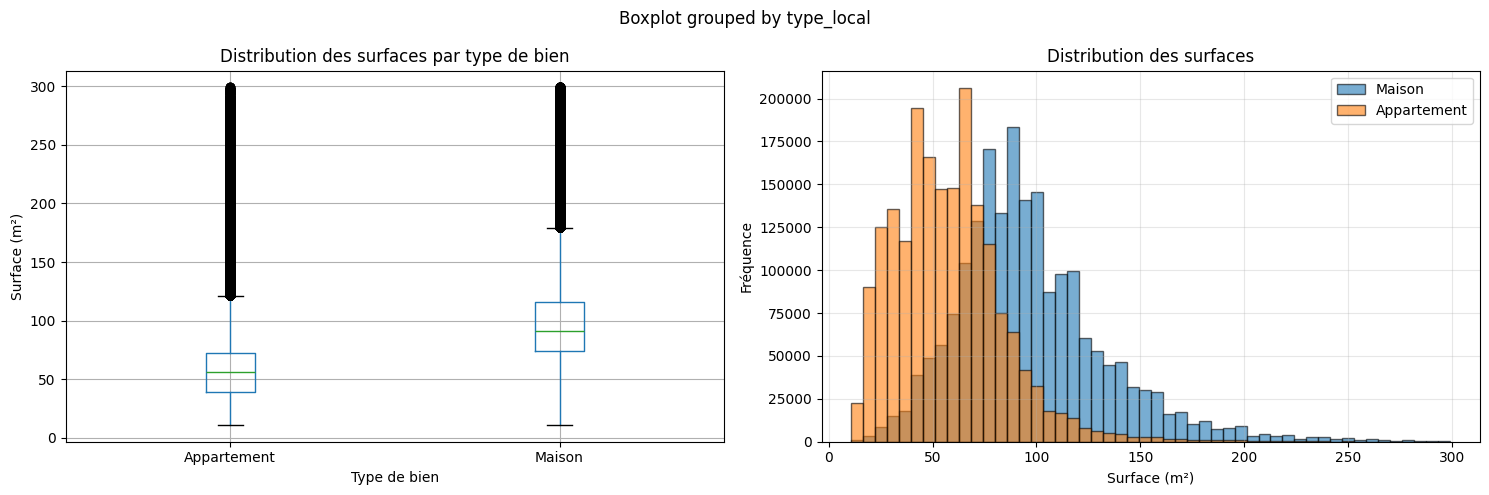

In [ ]:
data_visualization.surfaces(df_sans_lots_tronqué)

**Interprétation :** La distribution observée confirme nos hypothèses initiales. Les appartements présentent une médiane et une moyenne significativement plus faibles que les maisons, validant notre compréhension du marché immobilier français. Cette différence structurelle de surface aura des implications pour l'analyse des prix au mètre carré : une comparaison directe entre maisons et appartements nécessite de tenir compte de cette hétérogénéité fonctionnelle fondamentale.

### 2. Relation entre prix et surface immobilière

Au-delà de la distribution des surfaces, nous examinons comment le prix s'ajuste en fonction de la surface. Cette relation est fondamentale en économétrie immobilière : elle permet d'isoler le composant pur de valeur unitaire des effets de taille.


Statistiques du prix au m² par type de bien :
                 count         mean          std       min          25%  \
type_local                                                                
Appartement  1909159.0  4028.059164  2756.881215  0.014085  2200.000000   
Maison       1970693.0  2413.856134  1573.592881  0.005747  1366.197183   

                     50%          75%           max  
type_local                                           
Appartement  3325.641026  4885.714286  39428.571429  
Maison       2090.000000  3075.776596  53083.333333  


/home/onyxia/work/Python_2A/scripts/data_analysis.py:41: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



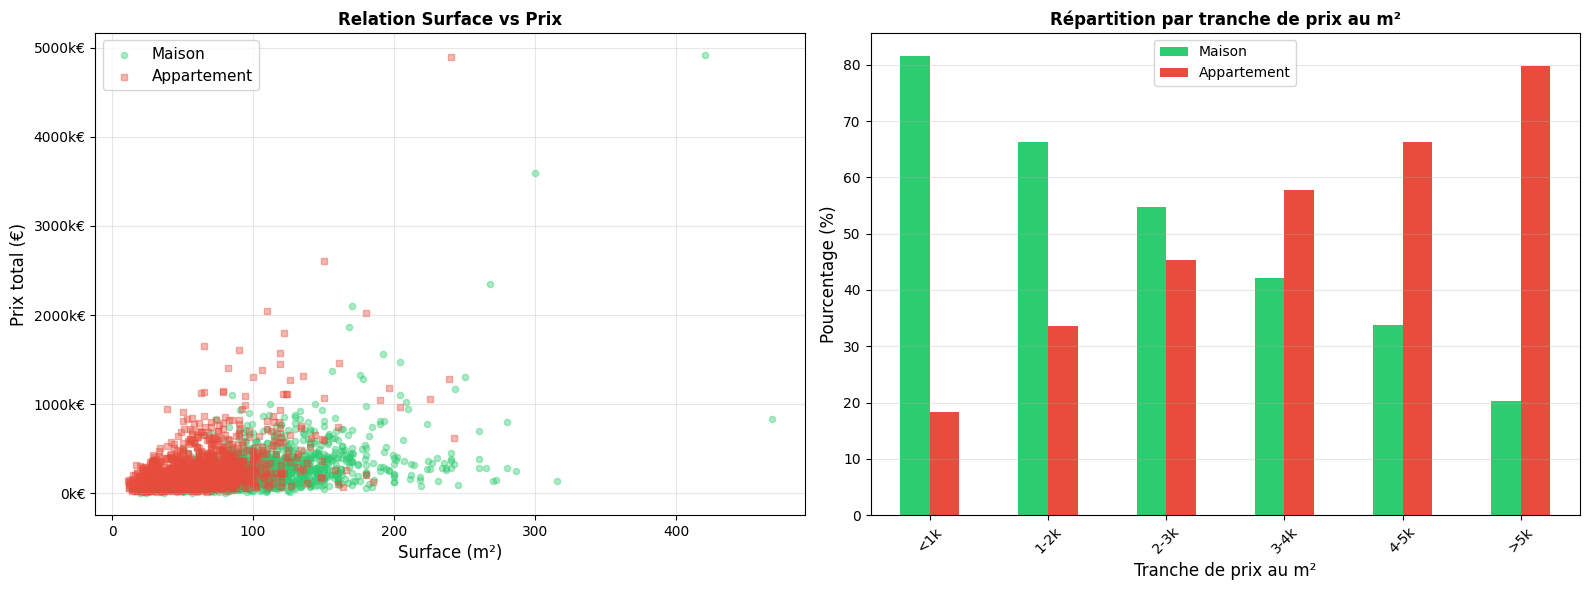

In [ ]:
data_analysis.relation_surface_prix(df_sans_lots_tronqué)


**Interprétation :** La relation positive forte entre surface et prix total est attendue : les biens plus grands se vendent plus cher en valeur absolue. Les écarts résiduels observables dans la dispersion des points révèlent cependant que d'autres facteurs jouent un rôle significatif. C'est précisément pour cette raison que nous utilisons le **prix au mètre carré** comme variable normalisée : elle élimine l'effet de taille et permet de comparer l'attractivité relative des territoires indépendamment de la structure de leurs marchés locaux.

### 3. Analyse de la densité de population

La densité de population est un indicateur synthétique reflétant l'urbanisation. Elle agit comme un proxy pour plusieurs phénomènes : accès aux services, dynamisme économique, offre d'emploi, environnement socio-culturel. Tous ces éléments influencent l'attractivité résidentielle et donc les prix immobiliers.


In [ ]:
# Extraire le département du code commune (2 premiers caractères)
df_sans_lots_tronqué['departement'] = df_sans_lots_tronqué['code_commune'].str[:2]

Statistiques calculées pour 3879852 départements

Top 10 départements par nombre de ventes :
   index id_mutation date_mutation  numero_disposition  \
0     17      2020-6    2020-07-02                   1   
1     31      2020-8    2020-07-01                   1   
2     32      2020-9    2020-07-02                   1   
3     36     2020-11    2020-07-03                   1   
4     37     2020-12    2020-07-02                   1   
5     41     2020-13    2020-07-03                   1   
6     43     2020-14    2020-07-02                   1   
7     45     2020-15    2020-07-02                   1   
8     51     2020-18    2020-07-07                   1   
9     53     2020-19    2020-07-09                   1   

                      nature_mutation  valeur_fonciere  adresse_numero  \
0                               Vente          77000.0           347.0   
1                               Vente         279000.0          1084.0   
2                               Vente         

In [ ]:
# # Données de densité de population par département (France métropolitaine)
# dept_data = {
#     '01': {'nom': 'Ain', 'population': 652000, 'superficie': 5762},
#     '02': {'nom': 'Aisne', 'population': 531000, 'superficie': 7369},
#     '03': {'nom': 'Allier', 'population': 335000, 'superficie': 7340},
#     '04': {'nom': 'Alpes-de-Haute-Provence', 'population': 164000, 'superficie': 6925},
#     '05': {'nom': 'Hautes-Alpes', 'population': 141000, 'superficie': 5549},
#     '06': {'nom': 'Alpes-Maritimes', 'population': 1083000, 'superficie': 4299},
#     '07': {'nom': 'Ardèche', 'population': 328000, 'superficie': 5529},
#     '08': {'nom': 'Ardennes', 'population': 270000, 'superficie': 5229},
#     '09': {'nom': 'Ariège', 'population': 153000, 'superficie': 4890},
#     '10': {'nom': 'Aube', 'population': 310000, 'superficie': 6004},
#     '11': {'nom': 'Aude', 'population': 374000, 'superficie': 6139},
#     '12': {'nom': 'Aveyron', 'population': 279000, 'superficie': 8735},
#     '13': {'nom': 'Bouches-du-Rhône', 'population': 2043000, 'superficie': 5087},
#     '14': {'nom': 'Calvados', 'population': 694000, 'superficie': 5548},
#     '15': {'nom': 'Cantal', 'population': 144000, 'superficie': 5726},
#     '16': {'nom': 'Charente', 'population': 352000, 'superficie': 5956},
#     '17': {'nom': 'Charente-Maritime', 'population': 651000, 'superficie': 6864},
#     '18': {'nom': 'Cher', 'population': 302000, 'superficie': 7235},
#     '19': {'nom': 'Corrèze', 'population': 240000, 'superficie': 5857},
#     '21': {'nom': "Côte-d'Or", 'population': 534000, 'superficie': 8763},
#     '22': {'nom': "Côtes-d'Armor", 'population': 600000, 'superficie': 6878},
#     '23': {'nom': 'Creuse', 'population': 116000, 'superficie': 5565},
#     '24': {'nom': 'Dordogne', 'population': 413000, 'superficie': 9060},
#     '25': {'nom': 'Doubs', 'population': 543000, 'superficie': 5234},
#     '26': {'nom': 'Drôme', 'population': 516000, 'superficie': 6530},
#     '27': {'nom': 'Eure', 'population': 599000, 'superficie': 6040},
#     '28': {'nom': 'Eure-et-Loir', 'population': 431000, 'superficie': 5880},
#     '29': {'nom': 'Finistère', 'population': 915000, 'superficie': 6733},
#     '30': {'nom': 'Gard', 'population': 748000, 'superficie': 5853},
#     '31': {'nom': 'Haute-Garonne', 'population': 1415000, 'superficie': 6309},
#     '32': {'nom': 'Gers', 'population': 191000, 'superficie': 6257},
#     '33': {'nom': 'Gironde', 'population': 1623000, 'superficie': 9976},
#     '34': {'nom': 'Hérault', 'population': 1175000, 'superficie': 6101},
#     '35': {'nom': 'Ille-et-Vilaine', 'population': 1079000, 'superficie': 6775},
#     '36': {'nom': 'Indre', 'population': 219000, 'superficie': 6791},
#     '37': {'nom': 'Indre-et-Loire', 'population': 610000, 'superficie': 6127},
#     '38': {'nom': 'Isère', 'population': 1271000, 'superficie': 7431},
#     '39': {'nom': 'Jura', 'population': 259000, 'superficie': 4999},
#     '40': {'nom': 'Landes', 'population': 413000, 'superficie': 9243},
#     '41': {'nom': 'Loir-et-Cher', 'population': 329000, 'superficie': 6343},
#     '42': {'nom': 'Loire', 'population': 765000, 'superficie': 4781},
#     '43': {'nom': 'Haute-Loire', 'population': 227000, 'superficie': 4977},
#     '44': {'nom': 'Loire-Atlantique', 'population': 1429000, 'superficie': 6815},
#     '45': {'nom': 'Loiret', 'population': 680000, 'superficie': 6775},
#     '46': {'nom': 'Lot', 'population': 174000, 'superficie': 5217},
#     '47': {'nom': 'Lot-et-Garonne', 'population': 333000, 'superficie': 5361},
#     '48': {'nom': 'Lozère', 'population': 76000, 'superficie': 5167},
#     '49': {'nom': 'Maine-et-Loire', 'population': 818000, 'superficie': 7166},
#     '50': {'nom': 'Manche', 'population': 496000, 'superficie': 5938},
#     '51': {'nom': 'Marne', 'population': 566000, 'superficie': 8162},
#     '52': {'nom': 'Haute-Marne', 'population': 172000, 'superficie': 6211},
#     '53': {'nom': 'Mayenne', 'population': 307000, 'superficie': 5175},
#     '54': {'nom': 'Meurthe-et-Moselle', 'population': 733000, 'superficie': 5246},
#     '55': {'nom': 'Meuse', 'population': 184000, 'superficie': 6211},
#     '56': {'nom': 'Morbihan', 'population': 750000, 'superficie': 6823},
#     '57': {'nom': 'Moselle', 'population': 1043000, 'superficie': 6216},
#     '58': {'nom': 'Nièvre', 'population': 204000, 'superficie': 6817},
#     '59': {'nom': 'Nord', 'population': 2604000, 'superficie': 5743},
#     '60': {'nom': 'Oise', 'population': 829000, 'superficie': 5860},
#     '61': {'nom': 'Orne', 'population': 279000, 'superficie': 6103},
#     '62': {'nom': 'Pas-de-Calais', 'population': 1465000, 'superficie': 6671},
#     '63': {'nom': 'Puy-de-Dôme', 'population': 662000, 'superficie': 7970},
#     '64': {'nom': 'Pyrénées-Atlantiques', 'population': 682000, 'superficie': 7645},
#     '65': {'nom': 'Hautes-Pyrénées', 'population': 229000, 'superficie': 4464},
#     '66': {'nom': 'Pyrénées-Orientales', 'population': 479000, 'superficie': 4116},
#     '67': {'nom': 'Bas-Rhin', 'population': 1140000, 'superficie': 4755},
#     '68': {'nom': 'Haut-Rhin', 'population': 767000, 'superficie': 3525},
#     '69': {'nom': 'Rhône', 'population': 1873000, 'superficie': 3249},
#     '70': {'nom': 'Haute-Saône', 'population': 235000, 'superficie': 5360},
#     '71': {'nom': 'Saône-et-Loire', 'population': 551000, 'superficie': 8575},
#     '72': {'nom': 'Sarthe', 'population': 566000, 'superficie': 6206},
#     '73': {'nom': 'Savoie', 'population': 436000, 'superficie': 6028},
#     '74': {'nom': 'Haute-Savoie', 'population': 825000, 'superficie': 4388},
#     '75': {'nom': 'Paris', 'population': 2161000, 'superficie': 105},
#     '76': {'nom': 'Seine-Maritime', 'population': 1255000, 'superficie': 6278},
#     '77': {'nom': 'Seine-et-Marne', 'population': 1421000, 'superficie': 5915},
#     '78': {'nom': 'Yvelines', 'population': 1431000, 'superficie': 2284},
#     '79': {'nom': 'Deux-Sèvres', 'population': 374000, 'superficie': 5999},
#     '80': {'nom': 'Somme', 'population': 570000, 'superficie': 6170},
#     '81': {'nom': 'Tarn', 'population': 387000, 'superficie': 5758},
#     '82': {'nom': 'Tarn-et-Garonne', 'population': 260000, 'superficie': 3718},
#     '83': {'nom': 'Var', 'population': 1076000, 'superficie': 5973},
#     '84': {'nom': 'Vaucluse', 'population': 559000, 'superficie': 3567},
#     '85': {'nom': 'Vendée', 'population': 685000, 'superficie': 6720},
#     '86': {'nom': 'Vienne', 'population': 438000, 'superficie': 6990},
#     '87': {'nom': 'Haute-Vienne', 'population': 374000, 'superficie': 5520},
#     '88': {'nom': 'Vosges', 'population': 364000, 'superficie': 5874},
#     '89': {'nom': 'Yonne', 'population': 338000, 'superficie': 7427},
#     '90': {'nom': 'Territoire de Belfort', 'population': 141000, 'superficie': 609},
#     '91': {'nom': 'Essonne', 'population': 1301000, 'superficie': 1804},
#     '92': {'nom': 'Hauts-de-Seine', 'population': 1609000, 'superficie': 176},
#     '93': {'nom': 'Seine-Saint-Denis', 'population': 1632000, 'superficie': 236},
#     '94': {'nom': "Val-de-Marne", 'population': 1398000, 'superficie': 245},
#     '95': {'nom': "Val-d'Oise", 'population': 1249000, 'superficie': 1246},
# }

# # Créer un DataFrame avec ces données
# df_dept_info = pd.DataFrame.from_dict(dept_data, orient='index')
# df_dept_info.index.name = 'departement'
# df_dept_info.reset_index(inplace=True)

# # Calculer la densité (habitants/km²)
# df_dept_info['densite'] = df_dept_info['population'] / df_dept_info['superficie']

# print(f"✓ Données chargées pour {len(df_dept_info)} départements")
# print("\n5 départements les plus denses :")
# print(df_dept_info.nlargest(5, 'densite')[['departement', 'nom', 'densite']])

# # Calculer les statistiques par département
# geo_stats = df.groupby(['departement', 'type_local']).size().unstack(fill_value=0)
# geo_stats['total'] = geo_stats.sum(axis=1)
# geo_stats['pct_maison'] = (geo_stats['Maison'] / geo_stats['total']) * 100
# geo_stats['pct_appartement'] = (geo_stats['Appartement'] / geo_stats['total']) * 100

# # Trier par nombre total de ventes
# geo_stats_sorted = geo_stats.sort_values('total', ascending=False)

# # Fusionner avec les données de densité
# geo_stats_with_info = geo_stats_sorted.reset_index().merge(df_dept_info, on='departement', how='left')

# # Créer une colonne pour l'affichage avec nom du département
# geo_stats_with_info['dept_nom'] = geo_stats_with_info['departement'] + ' - ' + geo_stats_with_info['nom'].fillna('Inconnu')


✓ Données chargées pour 94 départements

5 départements les plus denses :
   departement                nom       densite
73          75              Paris  20580.952381
90          92     Hauts-de-Seine   9142.045455
91          93  Seine-Saint-Denis   6915.254237
92          94       Val-de-Marne   5706.122449
93          95         Val-d'Oise   1002.407705


In [ ]:
from scripts.get_data import extract_departement, get_departements_from_geojson

print("✅ Calcul des statistiques départementales depuis les données communales...")

# Extraire le code département depuis le code commune
df_pop_dept = df_pop.copy()
df_pop_dept['departement'] = df_pop_dept['code_commune'].apply(extract_departement)

# Agréger population par département
df_dept_pop = (
    df_pop_dept
    .groupby('departement', as_index=False)
    .agg({'p19_pop': 'sum'})
    .rename(columns={'p19_pop': 'population'})
)

# Récupérer les superficies depuis le GeoJSON officiel
print("🌐 Récupération des superficies départementales depuis GeoJSON...")
df_dept_superficie = get_departements_from_geojson("Données/data/departements-100m.geojson")

# Fusionner population et superficie
df_dept_info = df_dept_pop.merge(
    df_dept_superficie,
    on='departement',
    how='left'
)

# Calculer la densité (habitants/km²)
df_dept_info['densite'] = df_dept_info['population'] / df_dept_info['superficie']

print(f"✅ Données calculées pour {len(df_dept_info)} départements")
print("\n5 départements les plus denses :")
print(df_dept_info.nlargest(5, 'densite')[['departement', 'nom', 'densite']])

# Calculer les statistiques par département
geo_stats = df_sans_lots_tronqué.groupby(['departement', 'type_local']).size().unstack(fill_value=0)
geo_stats['total'] = geo_stats.sum(axis=1)
geo_stats['pct_maison'] = (geo_stats['Maison'] / geo_stats['total']) * 100
geo_stats['pct_appartement'] = (geo_stats['Appartement'] / geo_stats['total']) * 100

# Trier par nombre total de ventes
geo_stats_sorted = geo_stats.sort_values('total', ascending=False)

# Fusionner avec les données de densité
geo_stats_with_info = geo_stats_sorted.reset_index().merge(df_dept_info, on='departement', how='left')

# Créer une colonne pour l'affichage avec nom du département
geo_stats_with_info['dept_nom'] = geo_stats_with_info['departement'] + ' - ' + geo_stats_with_info['nom'].fillna('Inconnu')



✅ Calcul des statistiques départementales depuis les données communales...
🌐 Récupération des superficies départementales depuis GeoJSON...
✅ Données calculées pour 100 départements

5 départements les plus denses :
   departement                nom       densite
75          75              Paris  20537.491371
92          92     Hauts-de-Seine   9263.183264
93          93  Seine-Saint-Denis   6939.588535
94          94       Val-de-Marne   5750.713736
95          95         Val-d'Oise    996.686238


In [ ]:
data_analysis.top_departements(geo_stats_with_info)

Statistiques calculées pour 94 départements

Top 10 départements par nombre de ventes :
             dept_nom  total  Maison  Appartement  pct_maison  pct_appartement  densite
            59 - Nord 146838  104630        42208        71.3             28.7      452
           75 - Paris 138828     472       138356         0.3             99.7    20537
13 - Bouches-du-Rhône 127066   37394        89672        29.4             70.6      402
 06 - Alpes-Maritimes 115391   12121       103270        10.5             89.5      255
           69 - Rhône 111014   24067        86947        21.7             78.3      577
         33 - Gironde 102125   57492        44633        56.3             43.7      157
         34 - Hérault 101162   42537        58625        42.0             58.0      189
  92 - Hauts-de-Seine  97639    9719        87920        10.0             90.0     9263
             83 - Var  96792   29274        67518        30.2             69.8      178
44 - Loire-Atlantique  93303   5

In [ ]:
data_visualization.scatter_prix_densite(geo_stats_with_info, df_final)

Relation Prix/m² vs Densité :
  Pente : 0.56 €/m² par unité de densité
  R² : 0.1723
  p-value : 0.0000e+00
  Interprétation : Un doublement de la densité est associé à une augmentation
  du prix au m² de ~0 € (approximativement, à échelle log).
  Communes analysées : 33066


**Analyse de la relation densité-prix :** Le graphique ci-dessus révèle une relation positive nette entre densité de population et prix au mètre carré. Cette corrélation s'explique par plusieurs mécanismes économiques imbriqués : dans les zones denses, l'offre de terrain constructible est limitée, ce qui exerce une pression haussière sur les prix. Parallèlement, ces territoires concentrent l'emploi, les services, et les aménités urbaines, générant une demande plus forte. La variabilité résiduelle autour de la tendance générale révèle néanmoins que la densité seule ne suffit pas à expliquer les prix. Des facteurs régionaux, historiques, ou liés à l'attrait spécifique de certains territoires continuent de jouer un rôle crucial.


In [ ]:

data_analysis.pourcentage_maisons_appartements(geo_stats_with_info)

**Décomposition du marché par type de bien :** Ce graphique révèle une variation importante dans la composition immobilière selon les départements. Les zones urbaines concentrent naturellement une plus grande part d'appartements, tandis que les territoires moins denses privilégient les maisons. Cette composition du parc immobilier a des implications importantes pour la politique du logement et pour la compréhension des préférences résidentielles régionales.


In [ ]:
data_visualization.correlation_densite_appartements(geo_stats_with_info)

**Corrélation densité et proportion d'appartements :** L'analyse de cette corrélation confirme un mécanisme fondamental d'organisation spatiale. À mesure que la densité s'accroît, la proportion d'appartements augmente selon une relation quasi-linéaire. Cette transition de l'habitat individuel vers l'habitat collectif répond à des impératifs économiques : il devient plus rentable de construire en hauteur lorsque la demande augmente et que le prix du terrain s'élève. Cela témoigne de l'efficacité du marché dans l'allocation des formes urbaines.


/home/onyxia/work/Python_2A/scripts/data_analysis.py:93: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



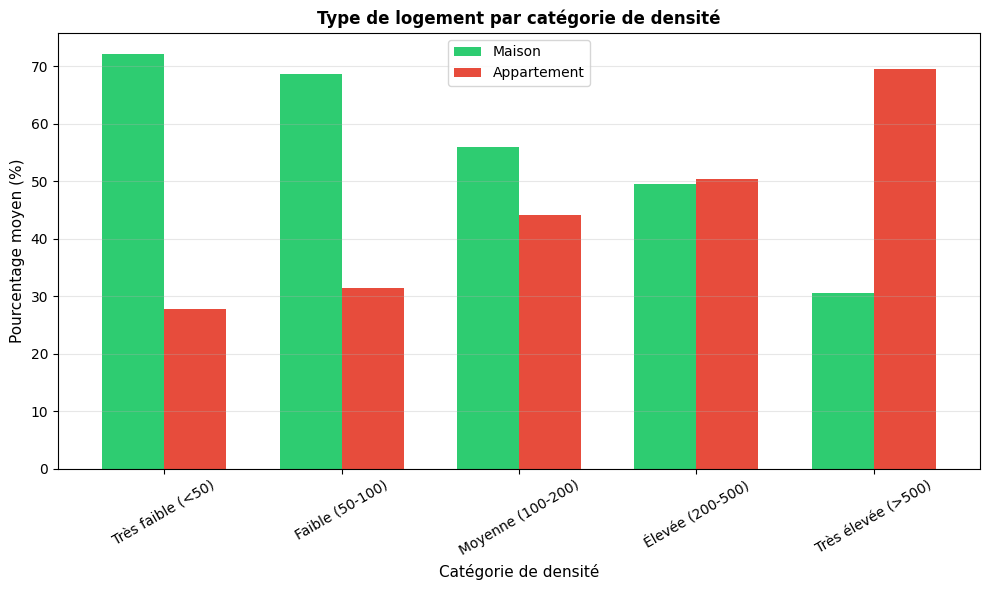

In [ ]:
data_analysis.histogramme_densite(geo_stats_with_info)

**Distribution départementale de la densité :** L'histogramme révèle une distribution fortement asymétrique de la densité entre départements. Quelques territoires fortement urbanisés (Île-de-France, côtes méditerranéennes) affichent des densités très élevées, tandis que la majorité des départements reste dans la fourchette 30-100 hab/km². Cette structure reflète l'organisation historique de la France, avec une concentration d'activités et de population dans quelques métropoles régionales et un espace péri-urbain et rural épars. Cette hétérogénéité spatiale constitue précisément l'objet de notre analyse : comprendre comment ces différences de contexte territorial se répercutent sur les dynamiques immobilières.


In [ ]:
# m = data_visualization.carte_a_densite(df)
# m
# m.save("/home/onyxia/work/Python_2A/carte_heatmap.html")
# On se contente ici de n'afficher qu'une capture d'écran de la carte interractive, car elle n'est pas supportée ici :

**Cartographie de la densité :** La visualisation géographique ci-dessus offre une perspective synthétique de la distribution spatiale du peuplement français. On y observe clairement le poids de l'agglomération parisienne, le long axe Rhône-Saône, le sillon Garonne-Toulouse, et les concentrations littorales. Ces zones de forte densité correspondent précisément aux territoires où les prix immobiliers sont les plus élevés. Inversement, les zones de densité faible (le Massif Central, certaines régions du sud-ouest, la Lozère) enregistrent des dynamiques immobilières plus modérées. Cette corrélation spatiale est au cœur de notre problématique : elle suggère que le contexte territorial agit comme un déterminant majeur de l'attractivité résidentielle.


## IV. Modélisation économétrique

L'objectif de cette section est de quantifier précisément comment les caractéristiques communales influencent les prix immobiliers. Après l'exploration descriptive, nous passons à une approche économétrique formelle permettant de tester des hypothèses et de mesurer l'effet marginal de chaque variable.

**Choix du modèle :** Nous adoptons une **spécification log-linéaire** où le logarithme du prix au mètre carré dépend linéairement des variables explicatives. Cette forme fonctionnelle présente plusieurs avantages :
- Elle correspond à une hypothèse raisonnable de rendements décroissants : chaque unité supplémentaire d'une variable explicative a un effet proportionnel, et non absolu
- Elle facilite l'interprétation : les coefficients s'interprètent comme des semi-élasticités (impact en pourcentage du prix)
- Elle réduit l'impact des valeurs extrêmes et améliore la normalité des résidus, hypothèse fondamentale pour l'inférence statistique

### 1. Sélection des variables explicatives

Notre analyse se concentre sur le prix au mètre carré des **appartements**, pour lesquels nous disposons d'un nombre d'observations suffisant permettant une estimation robuste. Les variables explicatives sélectionnées couvrent plusieurs dimensions de l'attrait communal :

**Variables démographiques :** composition des ménages, structures d'âge, qualification professionnelle
**Variables de logement :** type d'habitat, date de construction, états de vacance
**Variables socio-économiques :** taux de qualification, indicateurs d'attractivité

Le choix de ces variables s'appuie sur la théorie économique immobilière et sur une sélection pragmatique privilégiant :
- La disponibilité des données (franchir la limite des données manquantes)
- La variance suffisante (éviter les variables quasi-constantes)
- L'absence de multicolinéarité excessive entre explicatives

In [ ]:
commune_info = get_data.get_cloud_csv('dossier_complet',sep=';')

/home/onyxia/work/Python_2A/scripts/get_data.py:38: DtypeWarning:

Columns (0,1701,1702) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
commune_info

CODGEO  P22_POP  P22_POP0014  P22_POP1529  P22_POP3044  P22_POP4559  \
0       1001    859.0   162.000000   103.000000   157.000000   205.000000   
1       1002    273.0    57.000000    32.000000    58.000000    60.000000   
2       1004  15554.0  2992.348288  3161.190527  2998.287393  2661.947818   
3       1005   1917.0   362.644440   290.820926   389.153820   423.440841   
4       1006    114.0    10.000000    14.000000    20.000000    24.000000   
...      ...      ...          ...          ...          ...          ...   
34983  80830      NaN          NaN          NaN          NaN          NaN   
34984  85021      NaN          NaN          NaN          NaN          NaN   
34985  85233      NaN          NaN          NaN          NaN          NaN   
34986  88393      NaN          NaN          NaN          NaN          NaN   
34987  93059      NaN          NaN          NaN          NaN          NaN   

       P22_POP6074  P22_POP7589  P22_POP90P     P22_POPH  ...  BPE_2024_C303  \
0       156.000000    70.000000    6.000000   437.000000  ...            0.0   
1        43.000000    21.000000    2.000000   143.000000  ...            0.0   
2      2365.246638  1179.551751  195.427586  7490.936208  ...            0.0   
3       310.850701   128.442123   11.647148   959.490308  ...            0.0   
4        38.000000     8.000000    0.000000    60.000000  ...            0.0   
...            ...          ...         ...          ...  ...            ...   
34983          NaN          NaN         NaN          NaN  ...            NaN   
34984          NaN          NaN         NaN          NaN  ...            NaN   
34985          NaN          NaN         NaN          NaN  ...            NaN   
34986          NaN          NaN         NaN          NaN  ...            NaN   
34987          NaN          NaN         NaN          NaN  ...            NaN   

       BPE_2024_C304  BPE_2024_C305  BPE_2024_D250  BPE_2024_D265  \
0                0.0            0.0            0.0            0.0   
1                0.0            0.0            1.0            0.0   
2                0.0            0.0           12.0           25.0   
3                0.0            0.0            0.0            1.0   
4                0.0            0.0            0.0            0.0   
...              ...            ...            ...            ...   
34983            NaN            NaN            NaN            NaN   
34984            NaN            NaN            NaN            NaN   
34985            NaN            NaN            NaN            NaN   
34986            NaN            NaN            NaN            NaN   
34987            NaN            NaN            NaN            NaN   

       BPE_2024_D277  BPE_2024_D279  BPE_2024_D281  BPE_2024_D307  \
0                0.0            0.0            0.0            0.0   
1                0.0            0.0            0.0            0.0   
2               15.0           26.0           33.0            4.0   
3                2.0            2.0            3.0            1.0   
4                0.0            0.0            0.0            0.0   
...              ...            ...            ...            ...   
34983            NaN            NaN            NaN            NaN   
34984            NaN            NaN            NaN            NaN   
34985            NaN            NaN            NaN            NaN   
34986            NaN            NaN            NaN            NaN   
34987            NaN            NaN            NaN            NaN   

       BPE_2024_F307  
0                0.0  
1                0.0  
2                1.0  
3                1.0  
4                0.0  
...              ...  
34983            NaN  
34984            NaN  
34985            NaN  
34986            NaN  
34987            NaN  

[34988 rows x 1976 columns]

Les données brutes de l'INSEE fournissent des informations détaillées sur chaque commune, couvrant démographie, logement, emploi et statuts professionnels. Avant d'intégrer ces variables dans la régression, nous procédons à plusieurs opérations de nettoyage et sélection.


In [ ]:
commune_info['CODGEO'] = commune_info['CODGEO'].astype(str)
commune_info['CODGEO'] = commune_info['CODGEO'].str.zfill(5)
commune_info = commune_info.set_index('CODGEO')

commune_info

P22_POP  P22_POP0014  P22_POP1529  P22_POP3044  P22_POP4559  \
CODGEO                                                                
01001     859.0   162.000000   103.000000   157.000000   205.000000   
01002     273.0    57.000000    32.000000    58.000000    60.000000   
01004   15554.0  2992.348288  3161.190527  2998.287393  2661.947818   
01005    1917.0   362.644440   290.820926   389.153820   423.440841   
01006     114.0    10.000000    14.000000    20.000000    24.000000   
...         ...          ...          ...          ...          ...   
80830       NaN          NaN          NaN          NaN          NaN   
85021       NaN          NaN          NaN          NaN          NaN   
85233       NaN          NaN          NaN          NaN          NaN   
88393       NaN          NaN          NaN          NaN          NaN   
93059       NaN          NaN          NaN          NaN          NaN   

        P22_POP6074  P22_POP7589  P22_POP90P     P22_POPH    P22_H0014  ...  \
CODGEO                                                                  ...   
01001    156.000000    70.000000    6.000000   437.000000    95.000000  ...   
01002     43.000000    21.000000    2.000000   143.000000    27.000000  ...   
01004   2365.246638  1179.551751  195.427586  7490.936208  1531.743622  ...   
01005    310.850701   128.442123   11.647148   959.490308   190.111646  ...   
01006     38.000000     8.000000    0.000000    60.000000     5.000000  ...   
...             ...          ...         ...          ...          ...  ...   
80830           NaN          NaN         NaN          NaN          NaN  ...   
85021           NaN          NaN         NaN          NaN          NaN  ...   
85233           NaN          NaN         NaN          NaN          NaN  ...   
88393           NaN          NaN         NaN          NaN          NaN  ...   
93059           NaN          NaN         NaN          NaN          NaN  ...   

        BPE_2024_C303  BPE_2024_C304  BPE_2024_C305  BPE_2024_D250  \
CODGEO                                                               
01001             0.0            0.0            0.0            0.0   
01002             0.0            0.0            0.0            1.0   
01004             0.0            0.0            0.0           12.0   
01005             0.0            0.0            0.0            0.0   
01006             0.0            0.0            0.0            0.0   
...               ...            ...            ...            ...   
80830             NaN            NaN            NaN            NaN   
85021             NaN            NaN            NaN            NaN   
85233             NaN            NaN            NaN            NaN   
88393             NaN            NaN            NaN            NaN   
93059             NaN            NaN            NaN            NaN   

        BPE_2024_D265  BPE_2024_D277  BPE_2024_D279  BPE_2024_D281  \
CODGEO                                                               
01001             0.0            0.0            0.0            0.0   
01002             0.0            0.0            0.0            0.0   
01004            25.0           15.0           26.0           33.0   
01005             1.0            2.0            2.0            3.0   
01006             0.0            0.0            0.0            0.0   
...               ...            ...            ...            ...   
80830             NaN            NaN            NaN            NaN   
85021             NaN            NaN            NaN            NaN   
85233             NaN            NaN            NaN            NaN   
88393             NaN            NaN            NaN            NaN   
93059             NaN            NaN            NaN            NaN   

        BPE_2024_D307  BPE_2024_F307  
CODGEO                                
01001             0.0            0.0  
01002             0.0            0.0  
01004             4.0            1.0  
01005             1.0            1.0  


La documentation complète de l'INSEE détaille chaque indicateur avec ses définitions précises. Nous consultons cette ressource pour interpréter correctement chaque colonne et vérifier sa pertinence économique.


In [ ]:
commune_meta_info = get_data.get_cloud_csv('meta_dossier_complet',sep=';') 
commune_meta_info

/home/onyxia/work/Python_2A/scripts/get_data.py:38: DtypeWarning:

Columns (3,7) have mixed types. Specify dtype option on import or set low_memory=False.



COD_VAR                        LIB_VAR  \
0          P22_POP     Population en 2022 (princ)   
1      P22_POP0014   Pop 0-14 ans en 2022 (princ)   
2      P22_POP1529  Pop 15-29 ans en 2022 (princ)   
3      P22_POP3044  Pop 30-44 ans en 2022 (princ)   
4      P22_POP4559  Pop 45-59 ans en 2022 (princ)   
...            ...                            ...   
71810       CODGEO              Code géographique   
71811       CODGEO              Code géographique   
71812       CODGEO              Code géographique   
71813       CODGEO              Code géographique   
71814       CODGEO              Code géographique   

                                            LIB_VAR_LONG COD_MOD  \
0                                     Population en 2022     NaN   
1              Nombre de personnes de 0 à 14 ans en 2022     NaN   
2             Nombre de personnes de 15 à 29 ans en 2022     NaN   
3             Nombre de personnes de 30 à 44 ans en 2022     NaN   
4             Nombre de personnes de 45 à 59 ans en 2022     NaN   
...                                                  ...     ...   
71810  Code du département suivi du numéro de commune...   75116   
71811  Code du département suivi du numéro de commune...   75117   
71812  Code du département suivi du numéro de commune...   75118   
71813  Code du département suivi du numéro de commune...   75119   
71814  Code du département suivi du numéro de commune...   75120   

                        LIB_MOD TYPE_VAR  LONG_VAR  \
0                           NaN      NUM        16   
1                           NaN      NUM        17   
2                           NaN      NUM        17   
3                           NaN      NUM        17   
4                           NaN      NUM        17   
...                         ...      ...       ...   
71810  Paris 16e Arrondissement     CHAR         5   
71811  Paris 17e Arrondissement     CHAR         5   
71812  Paris 18e Arrondissement     CHAR         5   
71813  Paris 19e Arrondissement     CHAR         5   
71814  Paris 20e Arrondissement     CHAR         5   

                                         THEME  \
0      Évolution et structure de la population   
1      Évolution et structure de la population   
2      Évolution et structure de la population   
3      Évolution et structure de la population   
4      Évolution et structure de la population   
...                                        ...   
71810                                      NaN   
71811                                      NaN   
71812                                      NaN   
71813                                      NaN   
71814                                      NaN   

                                                  SOURCE  
0      Insee, RP2011, RP2016 et RP2022, géographie au...  
1      Insee, RP2011, RP2016 et RP2022, géographie au...  
2      Insee, RP2011, RP2016 et RP2022, géographie au...  
3      Insee, RP2011, RP2016 et RP2022, géographie au...  
4      Insee, RP2011, RP2016 et RP2022, géographie au...  
...                                                  ...  
71810                           Insee, COG au 01/01/2025  
71811                           Insee, COG au 01/01/2025  
71812                           Insee, COG au 01/01/2025  
71813                           Insee, COG au 01/01/2025  
71814                           Insee, COG au 01/01/2025  

[71815 rows x 9 columns]

In [ ]:
#nous allons imprimer une liste pour obtenir toutes ces informations
for i in commune_info.columns:
    lib = commune_meta_info.loc[commune_meta_info['COD_VAR'] == i, 'LIB_VAR_LONG'].values
    if lib.size > 0:
        print(f"{i} {lib[0]}")
    else:
        print(f"{i} errror")

P22_POP Population en 2022
P22_POP0014 Nombre de personnes de 0 à 14 ans en 2022
P22_POP1529 Nombre de personnes de 15 à 29 ans en 2022
P22_POP3044 Nombre de personnes de 30 à 44 ans en 2022
P22_POP4559 Nombre de personnes de 45 à 59 ans en 2022
P22_POP6074 Nombre de personnes de 60 à 74 ans en 2022
P22_POP7589 Nombre de personnes de 75 à 89 ans en 2022
P22_POP90P Nombre de personnes de 90 ans ou plus en 2022
P22_POPH Nombre total d'hommes en 2022
P22_H0014 Nombre d'hommes de 0 à 14 ans en 2022
P22_H1529 Nombre d'hommes de 15 à 29 ans en 2022
P22_H3044 Nombre d'hommes de 30 à 44 ans en 2022
P22_H4559 Nombre d'hommes de 45 à 59 ans en 2022
P22_H6074 Nombre d'hommes de 60 à 74 ans en 2022
P22_H7589 Nombre d'hommes de 75 à 89 ans en 2022
P22_H90P Nombre d'hommes de 90 ans ou plus en 2022
P22_H0019 Nombre d'hommes de 0 à 19 ans en 2022
P22_H2064 Nombre d'hommes de 20 à 64 ans en 2022
P22_H65P Nombre d'hommes de 65 ans ou plus en 2022
P22_POPF Nombre total de femmes en 2022
P22_F0014 Nombre

In [ ]:
#Nous allons maintenant imprimer le nombre de NaN que nous avons pour chaque colonne afin de voir combien 
# d'informations nous perdons en utilisant cette colonne comme variable explicative.
for col in commune_info.columns:
    n_nan = commune_info[col].isna().sum()  
    print(f"{col} - {n_nan}")

P22_POP - 89
P22_POP0014 - 89
P22_POP1529 - 89
P22_POP3044 - 89
P22_POP4559 - 89
P22_POP6074 - 89
P22_POP7589 - 89
P22_POP90P - 89
P22_POPH - 89
P22_H0014 - 89
P22_H1529 - 89
P22_H3044 - 89
P22_H4559 - 89
P22_H6074 - 89
P22_H7589 - 89
P22_H90P - 89
P22_H0019 - 89
P22_H2064 - 89
P22_H65P - 89
P22_POPF - 89
P22_F0014 - 89
P22_F1529 - 89
P22_F3044 - 89
P22_F4559 - 89
P22_F6074 - 89
P22_F7589 - 89
P22_F90P - 89
P22_F0019 - 89
P22_F2064 - 89
P22_F65P - 89
P22_POP01P - 89
P22_POP01P_IRAN1 - 89
P22_POP01P_IRAN2 - 89
P22_POP01P_IRAN3 - 89
P22_POP01P_IRAN4 - 89
P22_POP01P_IRAN5 - 89
P22_POP01P_IRAN6 - 89
P22_POP01P_IRAN7 - 89
P22_POP0114_IRAN2P - 89
P22_POP0114_IRAN2 - 89
P22_POP0114_IRAN3P - 89
P22_POP1524_IRAN2P - 89
P22_POP1524_IRAN2 - 89
P22_POP1524_IRAN3P - 89
P22_POP2554_IRAN2P - 89
P22_POP2554_IRAN2 - 89
P22_POP2554_IRAN3P - 89
P22_POP55P_IRAN2P - 89
P22_POP55P_IRAN2 - 89
P22_POP55P_IRAN3P - 89
C22_POP15P - 89
C22_POP15P_STAT_GSEC11_21 - 89
C22_POP15P_STAT_GSEC12_22 - 89
C22_POP15P_STAT_

In [ ]:
#nous définissons également l'index de df_final comme le code commune
df_final = df_final.set_index('code_commune')
df_final

population en 2019         nom de la commune  \
code_commune                                                 
01001                      779.0  L' Abergement-Clémenciat   
01002                      256.0    L' Abergement-de-Varey   
01004                    14134.0         Ambérieu-en-Bugey   
01005                     1751.0       Ambérieux-en-Dombes   
01006                      112.0                   Ambléon   
...                          ...                       ...   
97420                    24065.0            Sainte-Suzanne   
97421                     7136.0                   Salazie   
97422                    79824.0                 Le Tampon   
97423                     7015.0         Les Trois-Bassins   
97424                     5538.0                    Cilaos   

              nombre de ventes dans la commune            nom_commune  \
code_commune                                                            
01001                                     29.0  Abergement-Clémenciat   
01002                                     15.0    Abergement-de-Varey   
01004                                   1012.0      Ambérieu-en-Bugey   
01005                                    137.0    Ambérieux-en-Dombes   
01006                                     12.0                Ambléon   
...                                        ...                    ...   
97420                                    340.0         Sainte-Suzanne   
97421                                     68.0                Salazie   
97422                                   2477.0                 Tampon   
97423                                    141.0          Trois-Bassins   
97424                                     86.0                 Cilaos   

              nombre de ventes par habitant en 2019 dans la commune  \
code_commune                                                          
01001                                                       NaN       
01002                                                       NaN       
01004                                                  0.071600       
01005                                                  0.078241       
01006                                                       NaN       
...                                                         ...       
97420                                                  0.014128       
97421                                                  0.009529       
97422                                                  0.031031       
97423                                                  0.020100       
97424                                                  0.015529       

              médiane tronquée du prix au m2 maisons et appartements  \
code_commune                                                           
01001                                               2431.034483        
01002                                               1769.026549        
01004                                               2284.701114        
01005                                               2812.820513        
01006                                               1688.688525        
...                                                         ...        
97420                                               2169.996032        
97421                                               1458.185684        
97422                                               2228.571429        
97423                                               2500.000000        
97424                                               1578.947368        

              moyenne tronquée du prix au m2 maisons et appartements  \
code_commune                                                           
01001                                               2483.602665        
01002                                               1719.646511        
01004                                               2354.881148        
01005                               

In [ ]:
from scripts import global_variables
from scripts.data_clean import *
from scripts.global_variables import var_explicative_appartment

### 2. Régression log-OLS

La régression par Moindres Carrés Ordinaires (MCO) sur le logarithme du prix fournit nos estimations des coefficients. Cette approche reste la plus simple et la plus interprétable, tout en servant de référence pour les analyses ultérieures.


In [ ]:
X_appartment = prepare_regression_dataset(commune_info,var_explicative_appartment)
X_appartment 

In [ ]:
prix_m2_appartment  = df_final['moyenne tronquée du prix au m2 appartements'].dropna() 
prix_m2_appartment

In [ ]:
from scripts.do_ols import run_log_ols_regression

model = run_log_ols_regression(prix_m2_appartment, X_appartment)
print(model.summary())

                                         OLS Regression Results                                        
Dep. Variable:     moyenne tronquée du prix au m2 appartements   R-squared:                       0.294
Model:                                                     OLS   Adj. R-squared:                  0.292
Method:                                          Least Squares   F-statistic:                     122.0
Date:                                         Sun, 28 Dec 2025   Prob (F-statistic):          6.79e-255
Time:                                                 23:11:32   Log-Likelihood:                -1947.9
No. Observations:                                         3525   AIC:                             3922.
Df Residuals:                                             3512   BIC:                             4002.
Df Model:                                                   12                                         
Covariance Type:                                     nonrobust  

Info: 57 valeurs extrêmes retirées pour une meilleure visualisation


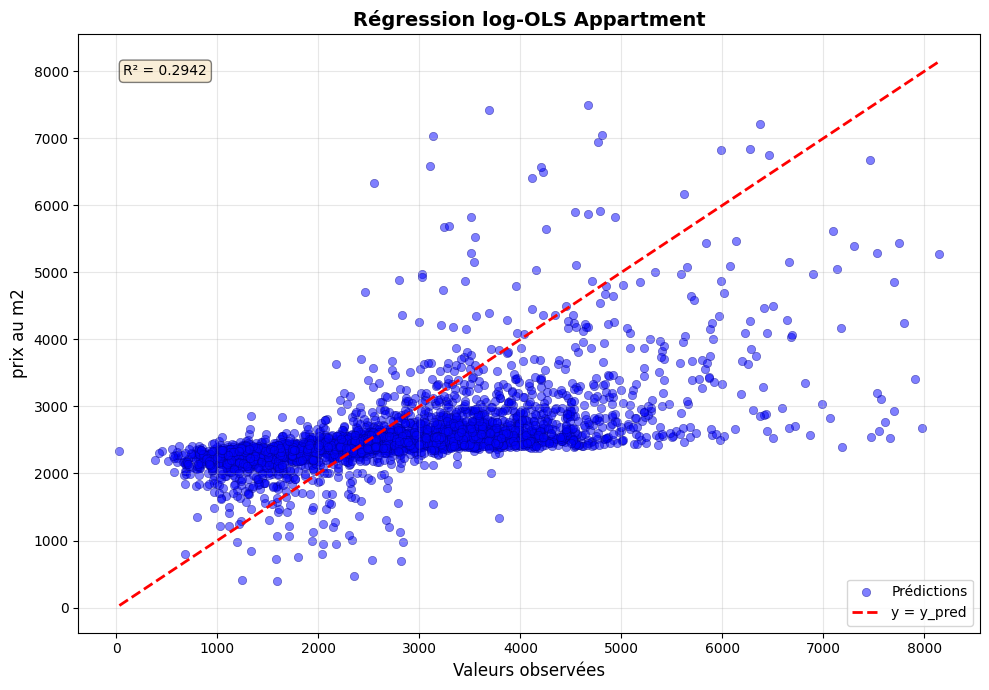

{'n_total': 3525,
 'n_plotted': 3468,
 'y_max': np.float64(14855.259131420997),
 'y_pred_max': np.float64(63233.817020770715)}

In [ ]:
from scripts.getvis import plot_log_ols_regression
plot_log_ols_regression(model,prix_m2_appartment,X_appartment,title='Régression log-OLS Appartment')

### 3. LASSO pour une régression plus parcimonieuse

In [ ]:
import numpy as np
from scripts.do_ols import run_log_lasso_cv

lasso_result = run_log_lasso_cv(
    prix_m2_appartment,
    X_appartment,
    alphas=np.logspace(-4, 1, 30),
    cv=5,
    random_state=42,
)

print(f"Alpha retenu (CV) : {lasso_result['alpha_']:.4f}")
print(f"Variables retenues : {lasso_result['n_features_selected']} sur {len(lasso_result['coefficients'])}")

coeffs = lasso_result["coefficients"]
non_zero = coeffs[coeffs != 0].sort_values(key=np.abs, ascending=False)
display(non_zero.to_frame("coef_normalises"))

Alpha retenu (CV) : 0.0016
Variables retenues : 9 sur 12


coef_normalises
C22_MENPSEUL                     -0.416666
C22_POP15P_STAT_GSEC13_23         0.370205
P22_POP4054                       0.230526
P22_LOGVAC                       -0.177642
P22_RSECOCC                       0.159927
P22_RPAPPART_ACH2019              0.142965
P22_POP2539                      -0.140028
P22_APPART                        0.032240
P22_RPAPPART_ACH1919              0.021191

Info: 57 valeurs extrêmes retirées pour une meilleure visualisation


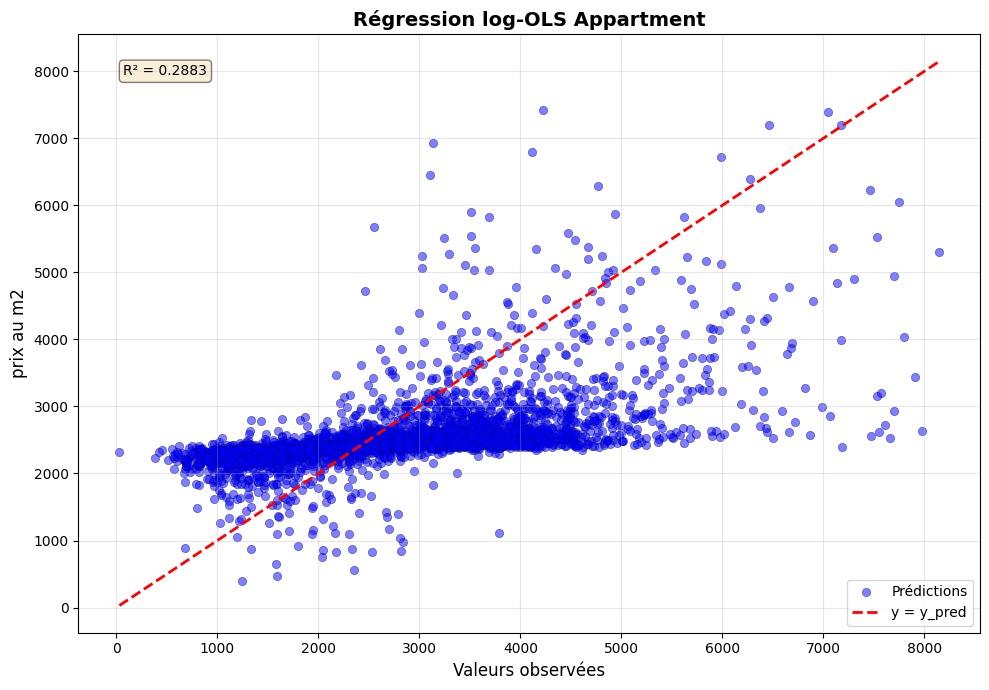

{'n_total': 3525,
 'n_plotted': 3468,
 'y_max': np.float64(14855.259131420997),
 'y_pred_max': np.float64(59359.879433214686)}

In [ ]:
from scripts.global_variables import var_explicative_appartment_lasso

X_appartment = prepare_regression_dataset(commune_info,var_explicative_appartment_lasso)
model = run_log_ols_regression(prix_m2_appartment, X_appartment)
plot_log_ols_regression(model,prix_m2_appartment,X_appartment,title='Régression log-OLS Appartment')

Le R2 n'a que légèrement diminué, mais le modèle est plus parcimonieux, ce qui semble tout de même préférable et plus robuste. 

**Diagnostic du modèle :** Ces graphiques permettent de vérifier que les hypothèses fondamentales du modèle de régression linéaire sont respectées. Un bon ajustement log-linéaire doit présenter des résidus approximativement distribués selon une loi normale et une variance constante (homoscédasticité). Ces diagnostics aident à valider la fiabilité des inférences statistiques.


In [ ]:
# Dans ce cas, nous avons effectué une régression du prix au m² des appartements à partir de 12 variables explicatives, à savoir :
#- Nombre d'appartements en 2022
#- Nombre de logements vacants en 2022
#- Nombre de résidences secondaires et logements occasionnels en 2022
#- Nombre de résidences principales d'1 pièce en 2022
#-Nombre de résidences principales de type appartement construites
#de 2006 à 2019 en 2022
#- Nombre de résidences principales de type appartement construites
#avant 1919 en 2022
#- Nombre de personnes de 25 à 39 ans vivant en couple en 2022
#- Nombre de personnes de 40 à 54 ans en 2022
#- Nombre de ménages d'une personne en 2022
#- Nombre de personnes des ménages en 2022
#- Nombre de ménages ayant emménagé depuis moins de 2 ans en 2022
#- Nombre de personnes de 15 ans ou plus Cadres et Professions
# intellectuelles supérieures en 2022

### 4. Interprétation des résultats

Notre régression intègre des variables explicatives couvrant les principales dimensions de l'attractivité communale : indicateurs de composition des ménages, structure du parc immobilier, présence de qualification professionnelle. Ces variables cumulées permettent de capturer les principaux déterminants territoriaux de l'attractivité résidentielle.

**Points clés d'interprétation :**
- Les **p-values** indiquent le niveau de confiance statistique : une p-value < 0,05 signifie que l'effet est statistiquement significatif
- Le **R²** mesure la proportion de variance des prix expliquée par le modèle
- Les **coefficients** s'interprètent comme des semi-élasticités : une augmentation unitaire produit un changement proportionnel du prix

La lecture détaillée des résultats permet d'identifier quelles dimensions de l'environnement communal jouent le rôle le plus important dans la formation des prix immobiliers.


## V. Conclusion et perspectives

### 1. Synthèse des résultats
En croisant plus d'un million de transactions DVF (2020-2025) avec des données socio-démographiques INSEE, nous montrons que l'hétérogénéité spatiale des prix n'est pas aléatoire : la densité urbaine, la composition du parc (appartements vs maisons) et la structure socio-professionnelle expliquent une part substantielle des écarts territoriaux. Le modèle log-linéaire capture l'essentiel des déterminants mesurables, tout en laissant une marge de variance liée à des facteurs locaux spécifiques.

### 2. Implications pour la politique du logement
Ces résultats invitent à des politiques différenciées : au niveau local, sécuriser l'emploi et l'offre de services peut renforcer l'attractivité des communes abordables ; au niveau régional, les investissements de transport et de désenclavement peuvent rééquilibrer les hiérarchies de prix ; au niveau national, desserrer les contraintes foncières dans les métropoles les plus tendues reste un levier central d'accessibilité.

### 3. Limites méthodologiques
L'analyse agrège à l'échelle communale et mélange des millésimes 2020-2025, ce qui atténue certaines dynamiques fines. Des risques d'endogénéité subsistent (causalité inverse entre attractivité et prix) et plusieurs facteurs qualitatifs ou institutionnels restent non observés, ce qui peut alimenter la part inexpliquée du modèle.

### 4. Pistes d'amélioration et recherches futures
Étendre l'approche avec des modèles spatiaux (SAR/SEM), travailler sur données de transactions individuelles, enrichir les variables qualitatives (aménités, mobilité, qualité scolaire), et suivre des trajectoires de communes dans le temps permettraient de préciser les mécanismes locaux et d'améliorer la robustesse des inférences.

### 5. Conclusion générale
Cette étude propose un diagnostic initial solide sur les déterminants territoriaux des prix immobiliers. Elle confirme que l'attractivité locale — densité, structure du bâti, profil socio-économique — exerce un rôle mesurable, mais qu'une part des dynamiques demeure propre à chaque territoire. Les données publiques françaises offrent un potentiel riche : les exploiter à plus fine échelle et avec des modèles spatiaux constitue la prochaine étape pour éclairer les choix de politique du logement.